# Fully Convolutional Watershed Distance Transform for 3D Data
---
Implementation of papers:

[Deep Watershed Transform for Instance Segmentation](http://openaccess.thecvf.com/content_cvpr_2017/papers/Bai_Deep_Watershed_Transform_CVPR_2017_paper.pdf)

[Learn to segment single cells with deep distance estimator and deep cell detector](https://arxiv.org/abs/1803.10829)

In [1]:
import os
import errno

import numpy as np

import sys
sys.path.insert(0,"/home/snn/deepcell-tf")

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


import deepcell

In [2]:
import math
import numpy as np
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import callbacks
from tensorflow.python.keras.optimizers import SGD

from tensorflow.python.keras.utils.data_utils import get_file

from deepcell import losses
import image_gen as image_gen
from deepcell import image_generators
from deepcell import model_zoo
from deepcell.layers import TensorProduct, ReflectionPadding3D, DilatedMaxPool3D, ConvGRU2D

from deepcell.utils import train_utils
from deepcell.utils.data_utils import get_data
from deepcell.utils.train_utils import rate_scheduler
from deepcell.training import train_model_conv


from tensorflow.python.keras.layers import MaxPool3D
from tensorflow.python.keras.layers import BatchNormalization, Dropout, LeakyReLU
from tensorflow.python.keras.layers import Conv3D, ZeroPadding3D, ConvLSTM2D, Cropping3D
from tensorflow.python.keras.layers import Input, Add, Concatenate, Flatten, Reshape
from tensorflow.python.keras.engine.input_layer import InputLayer

from tensorflow.python.keras.models import Model


from tensorflow.python.keras.regularizers import l2
from deepcell.layers import ImageNormalization2D, ImageNormalization3D
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Activation, Softmax

from sklearn.model_selection import train_test_split

from tensorflow.python.client import device_lib

### Load the Training Data

In [3]:
# If DATA_FILE exists just run this cell

from deepcell.utils.data_utils import get_data

DATA_DIR = '/data/training_data/tracking_benchmark_data'
DATA_FILE = os.path.join(DATA_DIR, '3T3_HeLa_HEK_RAW_cropped.npz')
# DATA_FILE = os.path.join(DATA_DIR, '3T3_HeLa_HEK_RAW_V2_stacked.npz')

# Load Information for hardcoded image size training
seed = 1
test_size = .2
train_dict, test_dict = get_data(DATA_FILE, seed=seed, test_size=test_size)
X_train, y_train = train_dict['X'], train_dict['y']
X_test, y_test = test_dict['X'], test_dict['y']

print(' -\nX.shape: {}\ny.shape: {}'.format(train_dict['X'].shape, train_dict['y'].shape))

 -
X.shape: (642, 30, 135, 160, 1)
y.shape: (642, 30, 135, 160, 1)


### Set up filepath constants

In [4]:
# Set up other required filepaths
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)
ROOT_DIR = '/data' # mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

## Define feature net models

#### feature_net_3D is the gru analog of bn_feature_net_3D

In [5]:
def feature_net_3D(receptive_field=61,
                    n_frames=5,
                    input_shape=(5, 256, 256, 1),
                    n_features=3,
                    n_channels=1,
                    reg=1e-5,
                    n_conv_filters=64,
                    n_dense_filters=200,
                    VGG_mode=False,
                    init='he_normal',
                    norm_method='std',
                    location=False,
                    dilated=False,
                    padding=False,
                    padding_mode='reflect',
                    multires=False,
                    include_top=True,
                    temporal=None,
                    temporal_kernel_size=3):
    # Create layers list (x) to store all of the layers.
    # We need to use the functional API to enable the multiresolution mode
    x = []

    win = (receptive_field - 1) // 2
    
    if temporal == "conv":
        win_z = (n_frames - 1) // 2
    else:
        win_z = 0

    if dilated:
        padding = True

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
        time_axis = 2
        row_axis = 3
        col_axis = 4
        if not dilated:
            input_shape = (n_channels, n_frames, receptive_field, receptive_field)
    else:
        channel_axis = -1
        time_axis = 1
        row_axis = 2
        col_axis = 3
        if not dilated:
            input_shape = (n_frames, receptive_field, receptive_field, n_channels)

    x.append(Input(shape=input_shape))
    x.append(ImageNormalization3D(norm_method=norm_method,
                                  filter_size=receptive_field)(x[-1]))

    if padding:
        if padding_mode == 'reflect':
            x.append(ReflectionPadding3D(padding=(win_z, win, win))(x[-1]))
        elif padding_mode == 'zero':
            x.append(ZeroPadding3D(padding=(win_z, win, win))(x[-1]))

    if location:
        x.append(Location3D(in_shape=tuple(x[-1].shape.as_list()[1:]))(x[-1]))
        x.append(Concatenate(axis=channel_axis)([x[-2], x[-1]]))

    layers_to_concat = []

    rf_counter = receptive_field
    block_counter = 0
    d = 1

    while rf_counter > 4:
        filter_size = 3 if rf_counter % 2 == 0 else 4
        x.append(Conv3D(n_conv_filters, (1, filter_size, filter_size),
                        dilation_rate=(1, d, d), kernel_initializer=init,
                        padding='valid', kernel_regularizer=l2(reg))(x[-1]))
        x.append(BatchNormalization(axis=channel_axis)(x[-1]))
        x.append(Activation('relu')(x[-1]))

        block_counter += 1
        rf_counter -= filter_size - 1

        if block_counter % 2 == 0:
            if dilated:
                x.append(DilatedMaxPool3D(dilation_rate=(1, d, d),
                                          pool_size=(1, 2, 2))(x[-1]))
                d *= 2
            else:
                x.append(MaxPool3D(pool_size=(1, 2, 2))(x[-1]))

            if VGG_mode:
                n_conv_filters *= 2

            rf_counter = rf_counter // 2

            if multires:
                layers_to_concat.append(len(x) - 1)

    if multires:
        c = []
        for l in layers_to_concat:
            output_shape = x[l].get_shape().as_list()
            target_shape = x[-1].get_shape().as_list()
            time_crop = (0, 0)

            row_crop = int(output_shape[row_axis] - target_shape[row_axis])

            if row_crop % 2 == 0:
                row_crop = (row_crop // 2, row_crop // 2)
            else:
                row_crop = (row_crop // 2, row_crop // 2 + 1)

            col_crop = int(output_shape[col_axis] - target_shape[col_axis])

            if col_crop % 2 == 0:
                col_crop = (col_crop // 2, col_crop // 2)
            else:
                col_crop = (col_crop // 2, col_crop // 2 + 1)

            cropping = (time_crop, row_crop, col_crop)

            c.append(Cropping3D(cropping=cropping)(x[l]))
        x.append(Concatenate(axis=channel_axis)(c))

    x.append(Conv3D(n_dense_filters, (1, rf_counter, rf_counter),
                    dilation_rate=(1, d, d), kernel_initializer=init,
                    padding='valid', kernel_regularizer=l2(reg))(x[-1]))
    x.append(BatchNormalization(axis=channel_axis)(x[-1]))
    x.append(Activation('relu')(x[-1]))
    
    print("temporal, ", temporal)
    if temporal == "conv":
        x.append(Conv3D(n_dense_filters, (n_frames, 1, 1), dilation_rate=(1, d, d),
                        kernel_initializer=init, padding='valid',
                        kernel_regularizer=l2(reg))(x[-1]))
        x.append(BatchNormalization(axis=channel_axis)(x[-1]))
        x.append(Activation('relu')(x[-1]))
    
    elif temporal == "gru":
        x.append(ConvGRU2D(filters=n_conv_filters, kernel_size=temporal_kernel_size,
                            padding='same', kernel_initializer=init, activation='relu',
                            kernel_regularizer=l2(reg), return_sequences=True)(x[-1]))
        x.append(BatchNormalization(axis=channel_axis)(x[-1]))
    elif temporal == "lstm":
        x.append(ConvLSTM2D(filters=n_conv_filters, kernel_size=temporal_kernel_size,
                            padding='same', kernel_initializer=init, activation='relu',
                            kernel_regularizer=l2(reg), return_sequences=True)(x[-1]))
        x.append(BatchNormalization(axis=channel_axis)(x[-1]))
    else:
        x.append(Conv3D(n_dense_filters, (1, 1, 1), dilation_rate=(1, d, d),
                        kernel_initializer=init, padding='valid',
                        kernel_regularizer=l2(reg))(x[-1]))
        x.append(BatchNormalization(axis=channel_axis)(x[-1]))
        x.append(Activation('relu')(x[-1]))


    x.append(TensorProduct(n_dense_filters, kernel_initializer=init,
                           kernel_regularizer=l2(reg))(x[-1]))
    x.append(BatchNormalization(axis=channel_axis)(x[-1]))
    x.append(Activation('relu')(x[-1]))

    x.append(TensorProduct(n_features, kernel_initializer=init,
                           kernel_regularizer=l2(reg))(x[-1]))

    if not dilated:
        x.append(Flatten()(x[-1]))

    if include_top:
        x.append(Softmax(axis=channel_axis)(x[-1]))

    model = Model(inputs=x[0], outputs=x[-1])
    model.summary()
    return model

#### feature_net_skip_3D is the gru analog of bn_feature_net_skip_3D

In [6]:
def feature_net_skip_3D(receptive_field=61,
                        input_shape=(5, 256, 256, 1),
                        fgbg_model=None,
                        temporal=None,
                        temporal_kernel_size=3,
                        last_only=True,
                        n_skips=1,
                        norm_method='whole_image',
                        padding_mode='reflect',
                        **kwargs):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    inputs = Input(shape=input_shape)
    img = ImageNormalization3D(norm_method=norm_method,
                               filter_size=receptive_field)(inputs)

    models = []
    model_outputs = []
    
    if fgbg_model is not None:
        for layer in fgbg_model.layers:
            layer.trainable = False
        models.append(fgbg_model)
        fgbg_output = fgbg_model(inputs)
        if isinstance(fgbg_output, list):
            fgbg_output = fgbg_output[-1]
        model_outputs.append(fgbg_output)

    for _ in range(n_skips + 1):
        if model_outputs:
            model_input = Concatenate(axis=channel_axis)([img, model_outputs[-1]])
        else:
            model_input = img

        new_input_shape = model_input.get_shape().as_list()[1:]
        models.append(feature_net_3D(receptive_field=receptive_field, 
                                     input_shape=new_input_shape, 
                                     norm_method=None, 
                                     dilated=True, 
                                     padding=True, 
                                     padding_mode=padding_mode, 
                                     temporal=temporal, 
                                     temporal_kernel_size=temporal_kernel_size, 
                                     **kwargs))
        model_outputs.append(models[-1](model_input))

    if last_only:
        model = Model(inputs=inputs, outputs=model_outputs[-1])
    elif fgbg_model is None:
        model = Model(inputs=inputs, outputs=model_outputs)
    else:
        model = Model(inputs=inputs, outputs=model_outputs[1:])
        
    model.summary()
    return model

#### Test Generator

In [7]:
DataGenerator = image_generators.MovieDataGenerator

datagen = DataGenerator(
    rotation_range=180,
    shear_range=False,
    zoom_range=(0.8, 1.2),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = DataGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=0,
    vertical_flip=0)


train_data = datagen.flow(
    train_dict,
    skip=3,
    seed=0,
    batch_size=1,
    transform='fgbg',
    transform_kwargs={},
    frames_per_batch=3)

val_data = datagen_val.flow(
    test_dict,
    skip=3,
    seed=0,
    batch_size=1,
    transform='fgbg',
    transform_kwargs={},
    frames_per_batch=3)

(642, 30, 135, 160, 1)
Image number: 456
Frame number: 8


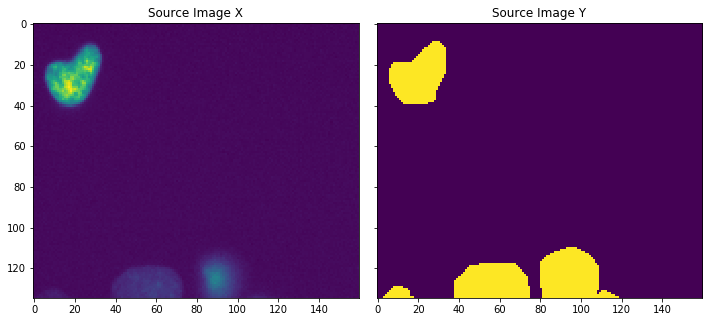

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

print(train_data.x.shape)

index = np.random.randint(low=0, high=train_data.x.shape[0])
frame = np.random.randint(low=0, high=train_data.x.shape[1])
print('Image number:', index)
print('Frame number:', frame)

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(train_data.x[index, frame, ..., 0])
ax[0].set_title('Source Image X')

ax[1].imshow(train_data.y[index, frame, ..., 1])
ax[1].set_title('Source Image Y')

fig.tight_layout()
plt.show()

## Train the Model

### Training Parameters

In [7]:
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler

fgbg_model_name = 'trackingSEG_cropped_gru_fgbg_model_10e_noreset'
conv_model_name = 'trackingSEG_cropped_gru_watershed_model_10e_noreset'

n_epoch = 5  # Number of training epochs
norm_method = 'whole_image'  # data normalization - `whole_image` for 3d conv
receptive_field = 61  # should be adjusted for the scale of the data

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

lr_sched = rate_scheduler(lr=0.01, decay=0.99)

# FC training settings
n_skips = 0  # number of skip-connections (only for FC training)
batch_size = 1  # FC training uses 1 image per batch

# Transformation settings
transform = 'watershed'
distance_bins = 4  # number of distance classes
erosion_width = 1  # erode edges, improves segmentation when cells are close

# 3D Settings
frames_per_batch = 3

# Temporal Settings
temporal = "gru"
temporal_kernel_size = 3

### Foreground Background Model

#### (1) Instantiate the fgbg model

In [8]:
fgbg_model = feature_net_skip_3D(
            n_features=2,  # segmentation mask (is_cell, is_not_cell)
            receptive_field=receptive_field,
            n_skips=n_skips,
            n_conv_filters=32,
            n_dense_filters=128,
            temporal=temporal,
            temporal_kernel_size=temporal_kernel_size,
            input_shape=tuple([frames_per_batch] + list(train_dict['X'].shape[2:])),
            last_only=False,
            norm_method=norm_method)

temporal,  gru
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3, 135, 160, 1)    0         
_________________________________________________________________
image_normalization3d_1 (Ima (None, 3, 135, 160, 1)    0         
_________________________________________________________________
reflection_padding3d (Reflec (None, 3, 195, 220, 1)    0         
_________________________________________________________________
conv3d (Conv3D)              (None, 3, 192, 217, 32)   544       
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 192, 217, 32)   128       
_________________________________________________________________
activation (Activation)      (None, 3, 192, 217, 32)   0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 3, 190, 215, 32)   9248  

In [9]:
fgbg_model.load_weights('/data/models/trackingSEG_cropped_gru_fgbg_model_5e_noreset.h5')

#### (2) Train the fgbg model

In [10]:
from deepcell.training import train_model_conv

fgbg_model = train_model_conv(
        model=fgbg_model,
        train_dict=train_dict,
        test_dict=test_dict,
        model_name=fgbg_model_name,
        log_dir=LOG_DIR,
        transform='fgbg',
        optimizer=optimizer,
        batch_size=batch_size,
        frames_per_batch=frames_per_batch,
        n_epoch=n_epoch,
        model_dir=MODEL_DIR,
        lr_sched=lr_sched,
        rotation_range=180,
        flip=True,
        shear=False,
        zoom_range=(0.8, 1.2))

fgbg_weights_file = os.path.join(MODEL_DIR, '{}.h5'.format(fgbg_model_name))
fgbg_model.save_weights(fgbg_weights_file)

X_train shape: (642, 30, 135, 160, 1)
y_train shape: (642, 30, 135, 160, 1)
X_test shape: (161, 30, 135, 160, 1)
y_test shape: (161, 30, 135, 160, 1)
Output Shape: (None, 3, 135, 160, 2)
Number of Classes: 2
Training on 1 GPUs
Epoch 1/5
641/642 [============================>.] - ETA: 0s - loss: 0.0961 - acc: 0.9648
Epoch 00001: val_loss improved from inf to 0.14626, saving model to /data/models/trackingSEG_cropped_gru_fgbg_model_10e_noreset.h5
642/642 [==============================] - 57s 89ms/step - loss: 0.0961 - acc: 0.9647 - val_loss: 0.1463 - val_acc: 0.9079
Epoch 2/5
641/642 [============================>.] - ETA: 0s - loss: 0.0967 - acc: 0.9651
Epoch 00002: val_loss did not improve from 0.14626
642/642 [==============================] - 50s 79ms/step - loss: 0.0967 - acc: 0.9651 - val_loss: 0.1652 - val_acc: 0.9263
Epoch 3/5
641/642 [============================>.] - ETA: 0s - loss: 0.0999 - acc: 0.9623
Epoch 00003: val_loss improved from 0.14626 to 0.10875, saving model to /da

### Watershed energy transform

#### (1) Load weights for fgbg model if necessary

In [9]:
fgbg_model = feature_net_skip_3D(
            n_features=2,  # segmentation mask (is_cell, is_not_cell)
            receptive_field=receptive_field,
            n_skips=n_skips,
            n_conv_filters=32,
            n_dense_filters=128,
            temporal=temporal,
            temporal_kernel_size=temporal_kernel_size,
            input_shape=tuple([frames_per_batch] + list(train_dict['X'].shape[2:])),
            last_only=False,
            )

fgbg_model.load_weights('/data/models/trackingSEG_cropped_gru_fgbg_model_5e.h5')

temporal,  gru
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3, 135, 160, 1)    0         
_________________________________________________________________
image_normalization3d_1 (Ima (None, 3, 135, 160, 1)    0         
_________________________________________________________________
reflection_padding3d (Reflec (None, 3, 195, 220, 1)    0         
_________________________________________________________________
conv3d (Conv3D)              (None, 3, 192, 217, 32)   544       
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 192, 217, 32)   128       
_________________________________________________________________
activation (Activation)      (None, 3, 192, 217, 32)   0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 3, 190, 215, 32)   9248  

#### (2) Instantiate the distance transform model 

In [11]:
watershed_model = feature_net_skip_3D(
    fgbg_model=fgbg_model,
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_features=distance_bins,  # (background edge, interior edge, cell interior, background)
    n_frames=frames_per_batch,
    n_conv_filters=32,
    n_dense_filters=128,
    temporal=temporal,
    temporal_kernel_size=temporal_kernel_size,
    multires=False,
    last_only=False,
    input_shape=tuple([frames_per_batch] + list(train_dict['X'].shape[2:])),
    norm_method=norm_method)

temporal,  gru
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3, 135, 160, 3)    0         
_________________________________________________________________
image_normalization3d_3 (Ima (None, 3, 135, 160, 3)    0         
_________________________________________________________________
reflection_padding3d_1 (Refl (None, 3, 195, 220, 3)    0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 3, 192, 217, 32)   1568      
_________________________________________________________________
batch_normalization_9 (Batch (None, 3, 192, 217, 32)   128       
_________________________________________________________________
activation_8 (Activation)    (None, 3, 192, 217, 32)   0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 3, 190, 215, 32)   9248  

In [12]:
watershed_model.load_weights('/data/models/trackingSEG_cropped_gru_watershed_model_5e_noreset.h5')

#### (3) Train the distance transform model

In [13]:
watershed_model = train_model_conv(
        model=watershed_model,
        train_dict=train_dict,
        test_dict=test_dict,
        model_name=conv_model_name,
        test_size=test_size,
        seed=seed,
        transform=transform,
        distance_bins=distance_bins,
        erosion_width=erosion_width,
        optimizer=optimizer,
        batch_size=batch_size,
        n_epoch=n_epoch,
        frames_per_batch=frames_per_batch,
        model_dir=MODEL_DIR,
        lr_sched=lr_sched,
        rotation_range=180,
        flip=True,
        shear=False,
        zoom_range=(0.8, 1.2))

watershed_weights_file = os.path.join(MODEL_DIR, '{}.h5'.format(conv_model_name))
watershed_model.save_weights(watershed_weights_file)

X_train shape: (642, 30, 135, 160, 1)
y_train shape: (642, 30, 135, 160, 1)
X_test shape: (161, 30, 135, 160, 1)
y_test shape: (161, 30, 135, 160, 1)
Output Shape: (None, 3, 135, 160, 4)
Number of Classes: 4
Training on 1 GPUs
Epoch 1/5
641/642 [============================>.] - ETA: 0s - loss: 0.6476 - acc: 0.8781
Epoch 00001: val_loss improved from inf to 0.63892, saving model to /data/models/trackingSEG_cropped_gru_watershed_model_10e_noreset.h5
642/642 [==============================] - 73s 114ms/step - loss: 0.6477 - acc: 0.8782 - val_loss: 0.6389 - val_acc: 0.8808
Epoch 2/5
641/642 [============================>.] - ETA: 0s - loss: 0.6323 - acc: 0.8844
Epoch 00002: val_loss improved from 0.63892 to 0.61176, saving model to /data/models/trackingSEG_cropped_gru_watershed_model_10e_noreset.h5
642/642 [==============================] - 67s 105ms/step - loss: 0.6322 - acc: 0.8844 - val_loss: 0.6118 - val_acc: 0.8637
Epoch 3/5
641/642 [============================>.] - ETA: 0s - loss: 

# Run the model

#### Make predictions on test data

In [94]:
temporal = "conv"

raw_trks_HEK  = os.path.join(RAW_BASE_DIR, 'HEK293_generic_test_BData.trks')
trks = load_trks(raw_trks_HEK)
lineages, X_test, y_test = trks['lineages'], trks['X'], trks['y']

run_fgbg_model = feature_net_skip_3D(
            n_features=2,  # segmentation mask (is_cell, is_not_cell)
            receptive_field=receptive_field,
            n_skips=n_skips,
            n_conv_filters=32,
            n_dense_filters=128,
            temporal=temporal,
            temporal_kernel_size=temporal_kernel_size,
            input_shape=tuple(X_test.shape[1:]),
            last_only=False,
            norm_method=norm_method)

run_fgbg_model.load_weights('/data/models/trackingSEG_cropped_conv_fgbg_model_5e.h5')

run_watershed_model = feature_net_skip_3D(
                        fgbg_model=run_fgbg_model,
                        receptive_field=receptive_field,
                        n_skips=n_skips,
                        n_features=distance_bins,
                        n_frames=frames_per_batch,
                        n_conv_filters=32,
                        n_dense_filters=128,
                        multires=False,
                        last_only=False,
                        input_shape=tuple(X_test.shape[1:]),
                        norm_method=norm_method,
                        temporal=temporal,
                        temporal_kernel_size=temporal_kernel_size)

run_watershed_model.load_weights('/data/models/trackingSEG_cropped_conv_watershed_model_5e.h5')

temporal,  conv
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_65 (InputLayer)        (None, 30, 135, 160, 1)   0         
_________________________________________________________________
image_normalization3d_64 (Im (None, 30, 135, 160, 1)   0         
_________________________________________________________________
reflection_padding3d_28 (Ref (None, 34, 195, 220, 1)   0         
_________________________________________________________________
conv3d_252 (Conv3D)          (None, 34, 192, 217, 32)  544       
_________________________________________________________________
batch_normalization_288 (Bat (None, 34, 192, 217, 32)  128       
_________________________________________________________________
activation_284 (Activation)  (None, 34, 192, 217, 32)  0         
_________________________________________________________________
conv3d_253 (Conv3D)          (None, 34, 190, 215, 32)  9248 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_66 (InputLayer)           (None, 30, 135, 160, 0                                            
__________________________________________________________________________________________________
image_normalization3d_65 (Image (None, 30, 135, 160, 0           input_66[0][0]                   
__________________________________________________________________________________________________
model_64 (Model)                (None, 30, 135, 160, 213570      input_66[0][0]                   
__________________________________________________________________________________________________
concatenate_12 (Concatenate)    (None, 30, 135, 160, 0           image_normalization3d_65[0][0]   
                                                                 model_64[1][0]                   
__________

In [95]:
# make predictions on testing data
test_images = run_watershed_model.predict(X_test[:1, :, :, :, :])# [-1]
test_images_fgbg = run_fgbg_model.predict(X_test[:1, :, :, :, :])# [-1]

print('watershed transform shape:', test_images.shape)
print('segmentation mask shape:', test_images_fgbg.shape)

watershed transform shape: (1, 30, 135, 160, 4)
segmentation mask shape: (1, 30, 135, 160, 2)


### Watershed post-processing

In [90]:
# Collapse predictions into semantic segmentation mask

argmax_images = []
for i in range(test_images.shape[0]):
    max_image = np.argmax(test_images[i], axis=-1)
    argmax_images.append(max_image)
argmax_images = np.array(argmax_images)
argmax_images = np.expand_dims(argmax_images, axis=-1)

print('watershed argmax shape:', argmax_images.shape)

watershed argmax shape: (1, 30, 135, 160, 1)


In [91]:
# threshold the foreground/background
# and remove background from watershed transform
threshold = 0.5
fg_thresh = test_images_fgbg[..., 1] > threshold

fg_thresh = np.expand_dims(fg_thresh.astype('int16'), axis=-1)
argmax_images_post_fgbg = argmax_images * fg_thresh

In [92]:
# Apply watershed method with the distance transform as seed
from skimage.measure import label
from skimage.morphology import watershed
from skimage.morphology import remove_small_objects
from skimage.feature import peak_local_max
from skimage.segmentation import relabel_sequential
from skimage.measure import label, regionprops

watershed_images = []
perimeter_area_threshold = 2
foreground = argmax_images_post_fgbg > 0
small_objects_threshold = 100

n_movies = argmax_images_post_fgbg.shape[0]
n_frames = argmax_images_post_fgbg.shape[1]

for i in range(n_movies):
    watershed_frames = []
    for j in range(n_frames):
        image = fg_thresh[i,j,...,0]
        semantic = fg_thresh[i,j,...]
        distance = argmax_images_post_fgbg[i,j,...,0]
        
        markers = label(distance == 3)
        labels = watershed(-distance, markers, mask=image)
        watershed_frames.append(labels)
    watershed_images.append(np.stack(watershed_frames, axis=0))

watershed_images = np.stack(watershed_images, axis=0)
watershed_images = np.expand_dims(watershed_images, axis=-1)
# for i in range(argmax_images_post_fgbg.shape[0]):
#     image = fg_thresh[i, ..., 0]
#     semantic = fg_thresh[i]
#     distance = argmax_images_post_fgbg[i, ..., 0]

#     markers = label(distance == 3)
#     local_maxi = peak_local_max(test_images[i, ..., -1], min_distance=15, 
#                                 exclude_border=False, indices=False, labels=image)

#     markers = label(local_maxi)
#     labels = watershed(-distance, markers, mask=image)
    
#     watershed_images.append(labels)
    

#     semantic_argmax = argmax_images[i]
    
#     watershed_sub_array = []
#     for i, segments_semantic in enumerate(segments):
#         masks_concat = image[i:i+1]
#         markers_semantic = markers[i]

#         # Remove misshapen watershed cells
#         props = regionprops(segments_semantic)
#         for prop in props:
#             if prop.perimeter ** 2 / prop.area > perimeter_area_threshold * 4 * np.pi:
#                 segments_semantic[segments_semantic == prop.label] = 0

#         masks_semantic = np.zeros((np.amax(segments_semantic).astype(int),
#                                    semantic.shape[1], semantic.shape[2]))
        
#         for j in range(0, masks_semantic.shape[0] + 1):
#             masks_semantic[j - 1] = segments_semantic == j
            
#         masks_concat = np.concatenate([masks_concat, masks_semantic], axis=0)
#         # print("masks_concat", masks_concat.shape)
#         label_image = np.sum(masks_concat, axis=0).astype(int)
#         # print("label_image", label_image.shape)
#         # Remove small objects
#         label_image = remove_small_objects(label_image, min_size=small_objects_threshold)
#         # Relabel the label image
#         label_image = label(label_image)
#         # print("label_image", label_image.shape)
#         watershed_sub_array.append(label_image)
#     watershed_images.append(watershed_sub_array)
        
# watershed_images = np.array(watershed_images)
# watershed_images = np.expand_dims(watershed_images, axis=-1)


### Plot the Results

Image number: 0
Frame: 24
(135, 160)


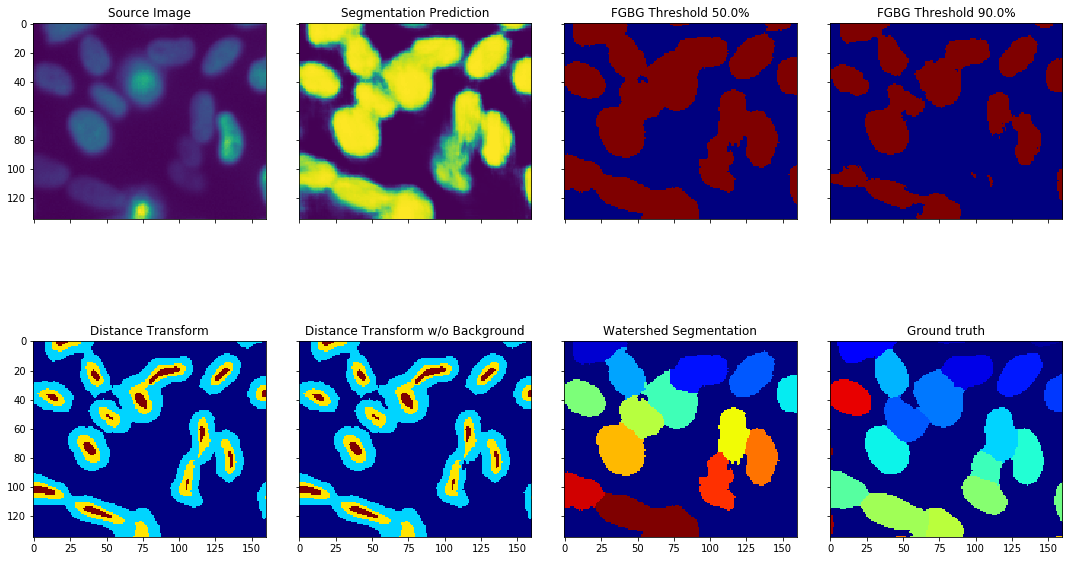

In [93]:
import matplotlib.pyplot as plt
%matplotlib inline

index = np.random.randint(low=0, high=1)
frame = np.random.randint(low=0, high=X_test.shape[1])
print('Image number:', index)
print('Frame:', frame)

print(markers.shape)

fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(15, 10), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, frame, ..., 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, frame, ..., 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(fg_thresh[index, frame, ..., 0], cmap='jet')
ax[2].set_title('FGBG Threshold {}%'.format(threshold * 100))

fg_thresh_90 = test_images_fgbg[..., 1] > 0.9
fg_thresh_90 = np.expand_dims(fg_thresh_90.astype('int16'), axis=-1)
ax[3].imshow(fg_thresh_90[index, frame, ..., 0], cmap='jet')
ax[3].set_title('FGBG Threshold {}%'.format(0.9 * 100))

ax[4].imshow(argmax_images[index, frame, ..., 0], cmap='jet')
ax[4].set_title('Distance Transform')

ax[5].imshow(argmax_images_post_fgbg[index, frame, ..., 0], cmap='jet')
ax[5].set_title('Distance Transform w/o Background')

ax[6].imshow(watershed_images[index, frame, ..., 0], cmap='jet')
ax[6].set_title('Watershed Segmentation')

ax[7].imshow(y_test[index, frame, ..., 0], cmap='jet')
ax[7].set_title('Ground truth')

fig.tight_layout()
plt.show()
# plt.savefig('test.png')

### Run the Model Iteratively

In [14]:
# Define the Datasets

###### For Deepcell Datasets

# Define data to load (raw images from trk test files)
RAW_BASE_DIR = '/data/training_data/tracking_benchmark_data/test'

raw_trks_3T3  = os.path.join(RAW_BASE_DIR, '3T3_NIH_test_BData.trks')
raw_trks_HEK  = os.path.join(RAW_BASE_DIR, 'HEK293_generic_test_BData.trks')
raw_trks_HeLa = os.path.join(RAW_BASE_DIR, 'HeLa_S3_test_BData.trks')
raw_trks_RAW  = os.path.join(RAW_BASE_DIR, 'RAW264_generic_test_BData.trks')

# raw_trks_files = [raw_trks_3T3, raw_trks_HEK, raw_trks_HeLa]
raw_trks_files = [raw_trks_3T3, raw_trks_HEK, raw_trks_HeLa, raw_trks_RAW]

# Define a base file name for the output
BASE_NAME = 'batch_'

In [18]:
# Make predictions on test data
from deepcell.utils.tracking_utils import load_trks
from skimage.morphology import remove_small_objects
import pandas as pd
from deepcell import metrics
from skimage.measure import label
from skimage import morphology
from skimage.morphology import watershed
from skimage.feature import peak_local_max

# CELL_TYPE_NAME = ['3T3', 'HEK293', 'HeLa']
CELL_TYPE_NAME = ['3T3', 'HEK293', 'HeLa', 'RAW264']
temporal = "gru"
temporal_kernel_size = 3

perimeter_area_threshold = 2

# threshold the foreground/background
# and remove back ground from edge transform
threshold = 0.9
Lstats_AllDatasets = []

# Go through each Dataset (3T3, HEK293, HeLa, RAW264.7)
for set_num, dataset in enumerate(raw_trks_files):
    # Load the trk file       
    trks = load_trks(dataset)
    lineages, raw, tracked = trks['lineages'], trks['X'], trks['y']
    
    run_fgbg_model = feature_net_skip_3D(
            n_features=2,  # segmentation mask (is_cell, is_not_cell)
            receptive_field=receptive_field,
            n_skips=n_skips,
            n_conv_filters=32,
            n_dense_filters=128,
            temporal=temporal,
            temporal_kernel_size=temporal_kernel_size,
            input_shape=tuple(trks['X'].shape[1:]),
            last_only=False,
            norm_method=norm_method)

    run_fgbg_model.load_weights('/data/models/trackingSEG_cropped_gru_fgbg_model_10e_noreset.h5')

    run_watershed_model = feature_net_skip_3D(
                        fgbg_model=run_fgbg_model,
                        receptive_field=receptive_field,
                        n_skips=n_skips,
                        n_features=distance_bins,
                        n_frames=frames_per_batch,
                        n_conv_filters=32,
                        n_dense_filters=128,
                        multires=False,
                        last_only=False,
                        input_shape=tuple(trks['X'].shape[1:]),
                        norm_method=norm_method,
                        temporal=temporal,
                        temporal_kernel_size=temporal_kernel_size)

    run_watershed_model.load_weights('/data/models/trackingSEG_cropped_gru_watershed_model_10e_noreset.h5')
    
    Lstats_allmovies = []

    # Go through each batch (movie) in each dataset
    for batch_num, movie in enumerate(trks['X']):
        print("batch_num: ", batch_num)
        Lstats = []
        
        # Predict on the raw data
        X_test_temp = np.expand_dims(movie, axis=0)
        y_test_temp = np.expand_dims(trks['y'][batch_num], axis=0)
        print("X_test_temp.shape", X_test_temp.shape)
        test_images = run_watershed_model.predict(X_test_temp) #[-1]
        test_images_fgbg = run_fgbg_model.predict(X_test_temp) #[-1]
        # 
        # Postprocessing
        # Collapse predictions into semantic segmentation mask
        argmax_images = []
        for frame_num, frame in enumerate(test_images):
            max_image = np.argmax(frame, axis=-1)
            argmax_images.append(max_image)
        argmax_images = np.array(argmax_images)
        argmax_images = np.expand_dims(argmax_images, axis=-1)
        
        # threshold the foreground/background
        # and remove background from watershed transform
        fg_thresh = test_images_fgbg[..., 1] > threshold
        fg_thresh = np.expand_dims(fg_thresh.astype('int16'), axis=-1)
        argmax_images_post_fgbg = argmax_images * fg_thresh
        watershed_images = []
        
        n_movies = argmax_images_post_fgbg.shape[0]
        n_frames = argmax_images_post_fgbg.shape[1]
        
        for i in range(n_movies):
            watershed_frames = []
            for j in range(n_frames):
                image = fg_thresh[i,j,...,0]
                semantic = fg_thresh[i,j,...]
                distance = argmax_images_post_fgbg[i,j,...,0]

                markers = label(distance == 3)
                labels = watershed(-distance, markers, mask=image)
                watershed_frames.append(labels)
            watershed_images.append(np.stack(watershed_frames, axis=0))

        watershed_images = np.stack(watershed_images, axis=0)
        watershed_images = np.expand_dims(watershed_images, axis=-1)

#         for i in range(argmax_images_post_fgbg.shape[0]):
#             image = fg_thresh[i, ..., 0]
#             semantic = fg_thresh[i]
#             distance = argmax_images_post_fgbg[i, ..., 0]

#             local_maxi = peak_local_max(test_images[i, ..., -1], min_distance=15, 
#                                         exclude_border=False, indices=False, labels=image)

#             markers = label(local_maxi)
#             segments = watershed(-distance, markers, mask=image)


#             semantic_argmax = argmax_images[i]

#             watershed_sub_array = []
#             for i, segments_semantic in enumerate(segments):
#                 masks_concat = image[i:i+1]
#                 markers_semantic = markers[i]

#                 # Remove misshapen watershed cells
#                 props = regionprops(segments_semantic)
#                 for prop in props:
#                     if prop.perimeter ** 2 / prop.area > perimeter_area_threshold * 4 * np.pi:
#                         segments_semantic[segments_semantic == prop.label] = 0

#                 masks_semantic = np.zeros((np.amax(segments_semantic).astype(int),
#                                            semantic.shape[1], semantic.shape[2]))

#                 for j in range(0, masks_semantic.shape[0] + 1):
#                     masks_semantic[j - 1] = segments_semantic == j

#                 masks_concat = np.concatenate([masks_concat, masks_semantic], axis=0)
#                 # print("masks_concat", masks_concat.shape)
#                 label_image = np.sum(masks_concat, axis=0).astype(int)
#                 # print("label_image", label_image.shape)
#                 # Remove small objects
#                 label_image = remove_small_objects(label_image, min_size=small_objects_threshold)
#                 # Relabel the label image
#                 label_image = label(label_image)
#                 # print("label_image", label_image.shape)
#                 watershed_sub_array.append(label_image)
#             watershed_images.append(watershed_sub_array)
#         watershed_images = np.array(watershed_images)
#         watershed_images = np.expand_dims(watershed_images, axis=-1)
        
        print("watershed_images.shape", watershed_images.shape)
        print("y_test_temp.shape", y_test_temp.shape)
        
        # Remove small objects from GT for comparison
        small_objects_threshold=100
        for i in range(watershed_images.shape[0]):
            for j in range(watershed_images.shape[1]):
                # Remove small objects from GT for comparison
                GT_image = y_test_temp[i, j, :, :, :]
                watershed_image = watershed_images[i, j, :, :, :]
                GT_image = np.expand_dims(GT_image, axis=0)
                watershed_image = np.expand_dims(watershed_image, axis=0)
                GT_image = morphology.remove_small_objects(GT_image.astype('uint16'), min_size=small_objects_threshold)

                pp_watershed_image = morphology.remove_small_objects(
                                        watershed_image.astype('uint16'), 
                                        min_size=small_objects_threshold)

                # Accuracy from metrics package
                filename = CELL_TYPE_NAME[set_num] + BASE_NAME + '{}'.format(i)

                m = metrics.Metrics(model_name = filename)
                m.calc_object_stats(GT_image, pp_watershed_image)

                Lstats.append(m.stats)
            
        Lstats_allmovies.append(Lstats)
        
    Lstats_AllDatasets.append(Lstats_allmovies)

df_3T3    = pd.concat([pd.concat(Lstats_AllDatasets[0][i]) for i in range(len(Lstats_AllDatasets[0]))])
df_HEK293 = pd.concat([pd.concat(Lstats_AllDatasets[1][i]) for i in range(len(Lstats_AllDatasets[1]))])
df_HeLa   = pd.concat([pd.concat(Lstats_AllDatasets[2][i]) for i in range(len(Lstats_AllDatasets[2]))])
df_RAW264 = pd.concat([pd.concat(Lstats_AllDatasets[3][i]) for i in range(len(Lstats_AllDatasets[3]))])

temporal,  gru
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 30, 154, 182, 1)   0         
_________________________________________________________________
image_normalization3d_21 (Im (None, 30, 154, 182, 1)   0         
_________________________________________________________________
reflection_padding3d_10 (Ref (None, 30, 214, 242, 1)   0         
_________________________________________________________________
conv3d_70 (Conv3D)           (None, 30, 211, 239, 32)  544       
_________________________________________________________________
batch_normalization_90 (Batc (None, 30, 211, 239, 32)  128       
_________________________________________________________________
activation_80 (Activation)   (None, 30, 211, 239, 32)  0         
_________________________________________________________________
conv3d_71 (Conv3D)           (None, 30, 209, 237, 32)  9248  

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           (None, 30, 154, 182, 0                                            
__________________________________________________________________________________________________
image_normalization3d_22 (Image (None, 30, 154, 182, 0           input_23[0][0]                   
__________________________________________________________________________________________________
model_21 (Model)                (None, 30, 154, 182, 257186      input_23[0][0]                   
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 30, 154, 182, 0           image_normalization3d_22[0][0]   
                                                                 model_21[1][0]                   
__________

/usr/local/lib/python3.5/dist-packages/deepcell/metrics.py:801: RuntimeWarning: invalid value encountered in long_scalars
  to_precision(100 * self.stats['gained_detections'].sum() / total_err, self.ndigits)))
/usr/local/lib/python3.5/dist-packages/deepcell/metrics.py:804: RuntimeWarning: invalid value encountered in long_scalars
  to_precision(100 * self.stats['missed_detections'].sum() / total_err, self.ndigits)))
/usr/local/lib/python3.5/dist-packages/deepcell/metrics.py:807: RuntimeWarning: invalid value encountered in long_scalars
  to_precision(100 * self.stats['merge'].sum() / total_err, self.ndigits)))
/usr/local/lib/python3.5/dist-packages/deepcell/metrics.py:810: RuntimeWarning: invalid value encountered in long_scalars
  to_precision(100 * self.stats['split'].sum() / total_err, self.ndigits)))
/usr/local/lib/python3.5/dist-packages/deepcell/metrics.py:813: RuntimeWarning: invalid value encountered in long_scalars
  to_precision(100 * self.stats['catastrophe'].sum() / total_e

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  8	Recall: 80%
Incorrect detections: 2	Precision: 80%

Gained detections: 2	Perc Error: 50%
Missed detections: 2	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.75294117647058822484495976823382079601287841796875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  8	Recall: 80%
Incorrect detections: 2	Precision: 80%

Gained detections: 2	Perc Error: 50%
Missed detections: 2	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Er

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 11

Correct detections:  11	Recall: 84.615384615384613198330043815076351165771484375%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.83398781313473258069990379226510412991046905517578125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  11	Recall: 91.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detecti


____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.90006112469437649092895981084438972175121307373046875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained d

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 4

Correct detections:  4	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8991741225051617103503076577908359467983245849609375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 6

Correct detections:  6	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Erro

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 5

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.86019929660023441986282932703034020960330963134765625 

batch_num:  2
X_test_temp.shape (1, 30, 154, 182, 1)
watershed_images.shape (1, 30, 154, 182, 1)
y_test_temp.shape (1, 30, 154, 182, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorr

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.91965590001623109817074919192236848175525665283203125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastr

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  9	Recall: 90%
Incorrect detections: 1	Precision: 90%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8851704022106232638833489545504562556743621826171875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 9

Correct detections:  9	Recall: 90%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 12

Correct detections:  12	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8427212874908558415398829311016015708446502685546875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 12

Correct detections:  12	Recall: 92.3076923076923065991650219075381755828857421875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Per

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  14	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.82024151811385859200953518666210584342479705810546875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 13

Correct detections:  13	Recall: 92.857142857142861203101347200572490692138671875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Per


____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.812905844155844103937624822719953954219818115234375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained det

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 6

Correct detections:  6	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8433102289434992737682250663056038320064544677734375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 6

Correct detections:  6	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 6

Correct detections:  6	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8364765919680496875088238084572367370128631591796875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.88420300214438884989220923671382479369640350341796875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastr

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 7

Correct detections:  7	Recall: 87.5%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.81229980781550292778803168403101153671741485595703125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 7

Correct detections:  7	Recall: 87.5%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Pe

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 8

Correct detections:  7	Recall: 77.77777777777777146184234879910945892333984375%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.70269398290046780619633182141114957630634307861328125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 8

Correct detections:  7	Recall: 77.77777777777777146184234879910945892333984375%
Inco

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 8

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.83702441794434978561412208364345133304595947265625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 9

Correct detections:  9	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
S


____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 10

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 2	Precision: 80%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 100%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.92817939469970200949688887703814543783664703369140625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 10

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 2	Precision: 80%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error


____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  6	Recall: 75%
Incorrect detections: 2	Precision: 75%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 50%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.90309869245925133984798094388679601252079010009765625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  6	Recall: 75%
Incorrect detections: 2	Precision: 75%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 50%
Catastrophes: 0		Perc Error: 0%

Gained detections from split

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  6	Recall: 75%
Incorrect detections: 2	Precision: 75%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 50%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.871688897238399373890160859446041285991668701171875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 9

Correct detections:  7	Recall: 87.5%
Incorrect detections: 2	Precision: 77.77777777777777146184234879910945892333984375%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 9

Correct detections:  8	Recall: 100%
Incorrect detections: 1	Precision: 88.888888888888885730921174399554729461669921875%

Gained detections: 1	Perc Error: 100%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8863315162527760637800611220882274210453033447265625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 9

Correct detections:  9	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 9

Correct detections:  6	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 3	Precision: 66.6666666666666714036182384006679058074951171875%

Gained detections: 1	Perc Error: 50%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 50%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.88115942028985505540816802749759517610073089599609375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 8

Correct detections:  7	Recall: 100%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 1	Perc Error: 100%
Missed detection


____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 9

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 1	Precision: 88.888888888888885730921174399554729461669921875%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.71539763113367171865064619851182214915752410888671875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 9

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 1	Precision: 88.888888888888885730921174399554729461669921875%

Gai

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 8

Correct detections:  7	Recall: 70%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 1	Perc Error: 25%
Missed detections: 3	Perc Error: 75%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.49787083037615331715386446376214735209941864013671875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 8

Correct detections:  6	Recall: 60%
Incorrect detections: 2	Precision: 75%

Gained detections: 2	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 4	Perc Error: 66.66666666666667140361823840

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 11

Correct detections:  7	Recall: 53.84615384615384670041748904623091220855712890625%
Incorrect detections: 4	Precision: 63.63636363636363313389665563590824604034423828125%

Gained detections: 3	Perc Error: 37.5%
Missed detections: 4	Perc Error: 50%
Merges: 1		Perc Error: 12.5%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.6207376478775226136264109300100244581699371337890625 

batch_num:  10
X_test_temp.shape (1, 30, 154, 182, 1)
watershed_images.shape (1, 30, 154, 182, 1)
y_test_temp.shape (1, 30, 154, 182, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predict

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 11

Correct detections:  11	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.80100956429330494312779364918242208659648895263671875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 10

Correct detections:  10	Recall: 90.909090909090906507117324508726596832275390625%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Per

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  11	Recall: 91.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.81636060100166940589616615397972054779529571533203125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  11	Recall: 91.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detect

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 8

Correct detections:  6	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 2	Precision: 75%

Gained detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Missed detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.76476066306574785880201261534239165484905242919921875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 8

Correct detections:  7	Recall: 100%
Incorrect detections: 1	Precision: 87.5%

Gained

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 9

Correct detections:  7	Recall: 87.5%
Incorrect detections: 2	Precision: 77.77777777777777146184234879910945892333984375%

Gained detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Missed detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.72112900019876768897830743298982270061969757080078125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 9

Correct detections:  7	Recall: 77.77777777777777146184234879910945892333984375%
Inco


____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 12

Correct detections:  10	Recall: 90.909090909090906507117324508726596832275390625%
Incorrect detections: 2	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Missed detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.910095290705703607869736515567637979984283447265625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 12

Correct detections:  10	Recall: 90.909090909090906507117324508726596832

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  9	Recall: 90%
Incorrect detections: 1	Precision: 90%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.90157201529528396832802172866649925708770751953125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  9	Recall: 90%
Incorrect detections: 1	Precision: 90%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Er

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 9

Correct detections:  7	Recall: 77.77777777777777146184234879910945892333984375%
Incorrect detections: 2	Precision: 77.77777777777777146184234879910945892333984375%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 50%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.88600244498777502855091370292939245700836181640625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 9

Correct detections:  7	Recall: 77.77777777777777146184234879910945892333984375%
Incorrect detections: 2	Precision: 77.777777777777771461842

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 11

Correct detections:  9	Recall: 81.81818181818181301423464901745319366455078125%
Incorrect detections: 2	Precision: 81.81818181818181301423464901745319366455078125%

Gained detections: 2	Perc Error: 50%
Missed detections: 2	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.74680488497585917340160222011036239564418792724609375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  8	Recall: 80%
Incorrect detections: 2	Precision: 80%

Gained detections: 2	Perc Error: 50%
Missed detections: 2

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 11

Correct detections:  9	Recall: 81.81818181818181301423464901745319366455078125%
Incorrect detections: 2	Precision: 81.81818181818181301423464901745319366455078125%

Gained detections: 2	Perc Error: 50%
Missed detections: 2	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.75960866526904258222430144087411463260650634765625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 11

Correct detections:  9	Recall: 81.81818181818181301423464901745319366455078125%
Incorrect detections: 2	Precision: 81.81818181818181301


____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.81602465331278895011024587802239693701267242431640625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained d

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 4

Correct detections:  4	Recall: 80%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.73130081300813010170003281018580310046672821044921875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 4

Correct detections:  3	Recall: 60%
Incorrect detections: 1	Precision: 75%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.66666666666667140361823840066

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 4

Correct detections:  3	Recall: 75%
Incorrect detections: 1	Precision: 75%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.79256155055002619480575276611489243805408477783203125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 4

Correct detections:  3	Recall: 60%
Incorrect detections: 1	Precision: 75%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.666666666666671403618238400667

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.88408942912958543569601488343323580920696258544921875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 83.333333333333


____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.88786449399656941494640705059282481670379638671875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		P


____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 11

Correct detections:  11	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.9408118081180811831387700294726528227329254150390625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 11

Correct detections:  11	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gai

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  10	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.94397003745318353029603031245642341673374176025390625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  10	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
C


____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 6

Correct detections:  6	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.83241914128995653232578888491843827068805694580078125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 6

Correct detections:  6	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc E

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.74920382165605092783522422905662097036838531494140625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastr

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 9

Correct detections:  9	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8012808072967203543157665990293025970458984375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 9

Correct detections:  9	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 13

Correct detections:  13	Recall: 92.857142857142861203101347200572490692138671875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8993798993798993723913781650480814278125762939453125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 13

Correct detections:  13	Recall: 92.857142857142861203101347200572490692138671875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detection

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  14	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.92439388716534531820201436858042143285274505615234375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  14	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
C


____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 7

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 2	Precision: 71.4285714285714306015506736002862453460693359375%

Gained detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Missed detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.75499398315282795213221334051922895014286041259765625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 8

Correct detections:  5	Recall: 83.333333333333328596381761599332094192504

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 9

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 1	Precision: 88.888888888888885730921174399554729461669921875%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.84505959246443673738014012997155077755451202392578125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 9

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 1	Precision: 88.888888888888885

watershed_images.shape (1, 30, 154, 182, 1)
y_test_temp.shape (1, 30, 154, 182, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  10	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.9267071320182094229522817840916104614734649658203125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  10	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detect

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 11

Correct detections:  11	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.9261189044756179544748420084943063557147979736328125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  10	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 90.909090909090906507117324508726596832275390625%

Gained detections: 0	Perc Error: 0%
Missed 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 13

Correct detections:  13	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8922223480131326045494688514736481010913848876953125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 13

Correct detections:  13	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Ca

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.84340909090909088607901367140584625303745269775390625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastr

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  6	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 1	Precision: 85.7142857142857081953479791991412639617919921875%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.740404040404040397760354608180932700634002685546875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 7

Correct detections:  5	Recall: 62.5%
Incorrect detections: 2	Precision: 71.4285714285714306015506736002862453460693359375%

Gained det


____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 8

Correct detections:  5	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect detections: 3	Precision: 62.5%

Gained detections: 3	Perc Error: 60%
Missed detections: 2	Perc Error: 40%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.75576694411414979679619818853097967803478240966796875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  5	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect detections: 2	Precision: 71.4285714285714306015506736002862453460693359375%

Gained detections: 2	Perc Error: 50%
Missed 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  7	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.84655335221907457299295174379949457943439483642578125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  7	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastr

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.89293747188484029475574743628385476768016815185546875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastr


Gained detections: 2	Perc Error: 50%
Missed detections: 2	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.77230483271375460763152887011528946459293365478515625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 10

Correct detections:  9	Recall: 75%
Incorrect detections: 1	Precision: 90%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 50%
Merges: 1		Perc Error: 50%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.819316586

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 12

Correct detections:  11	Recall: 100%
Incorrect detections: 1	Precision: 91.6666666666666714036182384006679058074951171875%

Gained detections: 1	Perc Error: 100%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.84111888111888111208003238061792217195034027099609375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 12

Correct detections:  11	Recall: 100%
Incorrect detections: 1	Precision: 91.6666666666666714036182384006679058074951171875%

Gained detections: 1	Perc Error: 100%
Missed dete

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 30, 135, 160, 1)   0         
_________________________________________________________________
image_normalization3d_24 (Im (None, 30, 135, 160, 1)   0         
_________________________________________________________________
model_24 (Model)             (None, 30, 135, 160, 2)   257186    
Total params: 257,186
Trainable params: 256,226
Non-trainable params: 960
_________________________________________________________________
temporal,  gru
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 30, 135, 160, 3)   0         
_________________________________________________________________
image_normalization3d_27 (Im (None, 30, 135, 160, 3)   0         
_____________________________________________________


____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 15

Correct detections:  13	Recall: 76.470588235294115975193562917411327362060546875%
Incorrect detections: 2	Precision: 86.6666666666666714036182384006679058074951171875%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Merges: 1		Perc Error: 33.33333333333333570180911920033395290374755859375%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 2
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.85714285714285709527615608749329112470149993896484375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 15

Correct detections:

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 17

Correct detections:  15	Recall: 88.2352941176470579875967814587056636810302734375%
Incorrect detections: 2	Precision: 88.2352941176470579875967814587056636810302734375%

Gained detections: 2	Perc Error: 50%
Missed detections: 2	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.79571185251978759911395400195033289492130279541015625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 15

Correct detections:  12	Recall: 70.588235294117652074419311247766017913818359375%
Incorrect detections: 3	Precision: 80%

Gaine


____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 15

Correct detections:  14	Recall: 82.3529411764705940868225297890603542327880859375%
Incorrect detections: 1	Precision: 93.3333333333333285963817615993320941925048828125%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 50%
Merges: 1		Perc Error: 50%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8369834710743802030918914169888012111186981201171875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 17

Correct detections:  13	Recall: 72.22222222222222853815765120089054107666015625%
Incorrect detections: 4	Precision: 76.470588235294115975193562917411327362060546875

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 17

Correct detections:  17	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.87544791795378718024522868290659971535205841064453125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 17

Correct detections:  17	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
C

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 18

Correct detections:  17	Recall: 89.4736842105263150415339623577892780303955078125%
Incorrect detections: 1	Precision: 94.4444444444444428654605871997773647308349609375%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 1		Perc Error: 100%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8459550561797752887827073209336958825588226318359375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 17

Correct detections:  15	Recall: 78.947368421052630083067924715578556060791015625%
Incorrect detections: 2	Precision: 88.23529411

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 20
Number of predicted cells:	 17

Correct detections:  14	Recall: 70%
Incorrect detections: 3	Precision: 82.3529411764705940868225297890603542327880859375%

Gained detections: 1	Perc Error: 25%
Missed detections: 1	Perc Error: 25%
Merges: 2		Perc Error: 50%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 3
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.85632570659488560504968290842953138053417205810546875 

batch_num:  2
X_test_temp.shape (1, 30, 135, 160, 1)
watershed_images.shape (1, 30, 135, 160, 1)
y_test_temp.shape (1, 30, 135, 160, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 15

Correct detections:  15	Recall: 93.75

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 17

Correct detections:  17	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8450999048525213996896354728960432112216949462890625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 17

Correct detections:  17	Recall: 94.4444444444444428654605871997773647308349609375%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Per

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 16

Correct detections:  16	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.86160806086777708134860631616902537643909454345703125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 16

Correct detections:  16	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
C

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 13

Correct detections:  11	Recall: 91.6666666666666714036182384006679058074951171875%
Incorrect detections: 2	Precision: 84.615384615384613198330043815076351165771484375%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 100%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.87226666666666663463303166281548328697681427001953125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 13

Correct detections:  11	Recall: 91.6666666666666714036182384006679058074951171875%
Incorrect detections: 2	Precision: 84.6153846

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  12	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 2	Precision: 85.7142857142857081953479791991412639617919921875%

Gained detections: 2	Perc Error: 50%
Missed detections: 2	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.831767719897523516436876889201812446117401123046875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 14

Correct detections:  13	Recall: 86.6666666666666714036182384006679058074951171875%
Incorrect detections: 1	Precision: 92.85714285

watershed_images.shape (1, 30, 135, 160, 1)
y_test_temp.shape (1, 30, 135, 160, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 10

Correct detections:  10	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8799483648881238906369617325253784656524658203125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 10

Correct detections:  10	Recall: 90.909090909090906507117324508726596832275390625%
Incorrect de

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 12

Correct detections:  12	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.83391304347826089582440545200370252132415771484375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 13

Correct detections:  12	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 1	Precision: 92.3076923076923065991650219075381755828857421875%

Gained

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 15

Correct detections:  13	Recall: 76.470588235294115975193562917411327362060546875%
Incorrect detections: 2	Precision: 86.6666666666666714036182384006679058074951171875%

Gained detections: 2	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 4	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.82741706467019493498327165070804767310619354248046875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 15

Correct detections:  15	Recall: 8

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  13	Recall: 92.857142857142861203101347200572490692138671875%
Incorrect detections: 1	Precision: 92.857142857142861203101347200572490692138671875%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8862808579522460927790916684898547828197479248046875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  14	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detecti

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 12

Correct detections:  12	Recall: 92.3076923076923065991650219075381755828857421875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.87053571428571430157461463750223629176616668701171875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  14	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Err


____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  10	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.89129208200112841620210701876203529536724090576171875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 9

Correct detections:  9	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gaine

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 8

Correct detections:  6	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 2	Precision: 75%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Merges: 1		Perc Error: 33.33333333333333570180911920033395290374755859375%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8377150275884452934604951224173419177532196044921875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 8

Correct detections:  6	Recall: 60%

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 9

Correct detections:  7	Recall: 58.33333333333333570180911920033395290374755859375%
Incorrect detections: 2	Precision: 77.77777777777777146184234879910945892333984375%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Merges: 2		Perc Error: 66.6666666666666714036182384006679058074951171875%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 2
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.86927356020942403436180256903753615915775299072265625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 9

Correct detections:  7	Recall: 63.63


____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 12

Correct detections:  12	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.9210480652437966764267684993683360517024993896484375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 13

Correct detections:  13	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gai

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  14	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.87585062240663902333182022630353458225727081298828125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 13

Correct detections:  11	Recall: 78.5714285714285693984493263997137546539306640625%
Incorrect detections: 2	Precision: 84.615384615384613198330043815076351165771484375%

Gained detections: 1	Perc Error: 33.333333


____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 15

Correct detections:  14	Recall: 77.77777777777777146184234879910945892333984375%
Incorrect detections: 1	Precision: 93.3333333333333285963817615993320941925048828125%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 1		Perc Error: 33.33333333333333570180911920033395290374755859375%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.847805897376364026030159948277287185192108154296875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 17

Correct detections:  16	Recall: 88.8888888888888857309211743995547294616

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 17

Correct detections:  16	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 1	Precision: 94.1176470588235360992257483303546905517578125%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 1		Perc Error: 100%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.87439613526570048041008931249962188303470611572265625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 16

Correct detections:  16	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detectio

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 18

Correct detections:  18	Recall: 94.7368421052631646261943387798964977264404296875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.87138223552894211731967288869782350957393646240234375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 19

Correct detections:  18	Recall: 94.7368421052631646261943387798964977264404296875%
Incorrect detections: 1	Precision: 94.7368421052631646261943387798964977264404296875%

Gai

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 12

Correct detections:  11	Recall: 73.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 91.6666666666666714036182384006679058074951171875%

Gained detections: 1	Perc Error: 20%
Missed detections: 4	Perc Error: 80%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.84921394395078608763327565611689351499080657958984375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 12

Correct detections:  11	Recall: 78.5714285714285693984493263997137546539306640625%
Incorrect detections: 1	Precision: 91.666666

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 10

Correct detections:  8	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 2	Precision: 80%

Gained detections: 0	Perc Error: 0%
Missed detections: 3	Perc Error: 75%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 25%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.84448903540203523743201685647363774478435516357421875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 10

Correct detections:  8	Recall: 61.53846153846154010125246713869273662567138671875%
Incorrect detections: 2	Precision: 80%

Gained detections: 0	Perc Error: 0%
Missed detection


____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 15

Correct detections:  15	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8993174061433446553337489604018628597259521484375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 15

Correct detections:  15	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 15

Correct detections:  13	Recall: 86.6666666666666714036182384006679058074951171875%
Incorrect detections: 2	Precision: 86.6666666666666714036182384006679058074951171875%

Gained detections: 2	Perc Error: 50%
Missed detections: 2	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.86501547987616100865437829270376823842525482177734375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 14

Correct detections:  12	Recall: 80%
Incorrect detections: 2	Precision: 85.7142857142857081953479791991412639617919921875%

Gain

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 14

Correct detections:  14	Recall: 93.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.858902717805435589326634726603515446186065673828125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 12

Correct detections:  11	Recall: 78.5714285714285693984493263997137546539306640625%
Incorrect detections: 1	Precision: 91.6666666666666714036182384006679058074951171875%

Gaine

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 12

Correct detections:  9	Recall: 69.23076923076922639666008763015270233154296875%
Incorrect detections: 3	Precision: 75%

Gained detections: 1	Perc Error: 20%
Missed detections: 3	Perc Error: 60%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 20%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8193509615384615418776093065389432013034820556640625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 13

Correct detections:  8	Recall: 72.7272727272727337322066887281835079193115234375%
Incorrect detections: 5	Precision: 61.53846153846154010125246713869273662567138671875%

Gained 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 12

Correct detections:  8	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 4	Precision: 66.6666666666666714036182384006679058074951171875%

Gained detections: 1	Perc Error: 25%
Missed detections: 1	Perc Error: 25%
Merges: 1		Perc Error: 25%
Splits: 1		Perc Error: 25%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8681290973272819400108346599154174327850341796875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 13

Correct detections:  11	Recall: 91.6666666666666714036182384006679058074951171875%
Incorrect detections: 2	Precision: 84.615384615


____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 12

Correct detections:  12	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8512374581939798900975802098400890827178955078125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 12

Correct detections:  12	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 12

Correct detections:  12	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8770890906698249889217322561307810246944427490234375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 11

Correct detections:  11	Recall: 84.615384615384613198330043815076351165771484375%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detectio

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 13

Correct detections:  13	Recall: 86.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.84003925417075564485713812246103771030902862548828125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 13

Correct detections:  13	Recall: 86.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detect

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 18

Correct detections:  16	Recall: 84.2105263157894796677283011376857757568359375%
Incorrect detections: 2	Precision: 88.888888888888885730921174399554729461669921875%

Gained detections: 2	Perc Error: 40%
Missed detections: 3	Perc Error: 60%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.81637773722627737793544611122342757880687713623046875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 20
Number of predicted cells:	 18

Correct detections:  15	Recall: 75%
Incorrect detections: 3	Precision: 83.3333333333333285963817615993320941925048828125%

Gained d

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 18

Correct detections:  17	Recall: 89.4736842105263150415339623577892780303955078125%
Incorrect detections: 1	Precision: 94.4444444444444428654605871997773647308349609375%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 1		Perc Error: 100%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8456439393939394477683890727348625659942626953125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 18

Correct detections:  18	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detectio

watershed_images.shape (1, 30, 135, 160, 1)
y_test_temp.shape (1, 30, 135, 160, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 12

Correct detections:  12	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.85255493433883755560742656598449684679508209228515625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 16

Correct detections:  15	Recall: 100%
Incorrect detections: 1	Precision: 93.75%

Gained det

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 14

Correct detections:  13	Recall: 86.6666666666666714036182384006679058074951171875%
Incorrect detections: 1	Precision: 92.857142857142861203101347200572490692138671875%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.84895702437798437056670763922738842666149139404296875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 14

Correct detections:  13	Recall: 8

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 15

Correct detections:  14	Recall: 82.3529411764705940868225297890603542327880859375%
Incorrect detections: 1	Precision: 93.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 25%
Missed detections: 3	Perc Error: 75%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8532509989102796676974094225442968308925628662109375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 16

Correct detections:  16	Recall: 94.1176470588235360992257483303546905517578125%
Incorrect detections: 0	Precision: 100%

Gained 


____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 14

Correct detections:  11	Recall: 64.7058823529411739627903443761169910430908203125%
Incorrect detections: 3	Precision: 78.5714285714285693984493263997137546539306640625%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 3		Perc Error: 100%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 3
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.85130149620823936107427698516403324902057647705078125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 15

Correct detections:  13	Recall: 72.22222222222222853815765120089054107666015625%
Incorrect detections: 2	Precision: 86.66666666666667140361823840066790580749511718

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 14

Correct detections:  10	Recall: 55.5555555555555571345394128002226352691650390625%
Incorrect detections: 4	Precision: 71.4285714285714306015506736002862453460693359375%

Gained detections: 1	Perc Error: 16.666666666666667850904559600166976451873779296875%
Missed detections: 2	Perc Error: 33.33333333333333570180911920033395290374755859375%
Merges: 3		Perc Error: 50%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 3
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.826517967781908335922480546287260949611663818359375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 12

Correct detections:  7	Recall: 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 21
Number of predicted cells:	 18

Correct detections:  14	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 4	Precision: 77.77777777777777146184234879910945892333984375%

Gained detections: 3	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 5	Perc Error: 55.5555555555555571345394128002226352691650390625%
Merges: 1		Perc Error: 11.111111111111110716365146799944341182708740234375%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.75744800449690841137595498366863466799259185791015625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 21
Number of predic

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 17

Correct detections:  16	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 1	Precision: 94.1176470588235360992257483303546905517578125%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 1		Perc Error: 100%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8751267891355798411723299068398773670196533203125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 18

Correct detections:  18	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 15

Correct detections:  13	Recall: 76.470588235294115975193562917411327362060546875%
Incorrect detections: 2	Precision: 86.6666666666666714036182384006679058074951171875%

Gained detections: 1	Perc Error: 25%
Missed detections: 2	Perc Error: 50%
Merges: 1		Perc Error: 25%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.863247863247863289615224857698194682598114013671875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 16

Correct detections:  13	Recall: 76.470588235294115975193562917411327362060546875%
Incorrect detections: 3	Precision: 81.25%

Gain


____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 14

Correct detections:  11	Recall: 64.7058823529411739627903443761169910430908203125%
Incorrect detections: 3	Precision: 78.5714285714285693984493263997137546539306640625%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 3		Perc Error: 100%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 3
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.903198551599275756274209925322793424129486083984375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 14

Correct detections:  11	Recall: 64.7058823529411739627903443761169910430908203125%
Incorrect detections: 3	Precision: 78.57142857142856939844932639971375465393066406

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 16

Correct detections:  13	Recall: 72.22222222222222853815765120089054107666015625%
Incorrect detections: 3	Precision: 81.25%

Gained detections: 1	Perc Error: 25%
Missed detections: 1	Perc Error: 25%
Merges: 2		Perc Error: 50%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 2
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.83728010825439780351331364727229811251163482666015625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 19

Correct detections:  16	Recall: 84.2105263157894796677283011376857757568359375%
Incorrect detections: 3	Precision: 84.2105263157894796677283011376857757568359375%

Gained d

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 21
Number of predicted cells:	 16

Correct detections:  14	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 2	Precision: 87.5%

Gained detections: 0	Perc Error: 0%
Missed detections: 3	Perc Error: 60%
Merges: 2		Perc Error: 40%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 2
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.83752478347072945030760138251935131847858428955078125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 21
Number of predicted cells:	 18

Correct detections:  17	Recall: 80.9523809523809489974155439995229244232177734375%
Incorrect detections: 1	Precision: 94.4444444444444428654605871997773647308349609375%

Ga

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 14

Correct detections:  13	Recall: 76.470588235294115975193562917411327362060546875%
Incorrect detections: 1	Precision: 92.857142857142861203101347200572490692138671875%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 1		Perc Error: 33.33333333333333570180911920033395290374755859375%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.88853678699366211990451347446651197969913482666015625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 13

Correct detections:  10	Recall: 58

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 14

Correct detections:  14	Recall: 87.5%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.85190198998240151961880428643780760467052459716796875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 15

Correct detections:  14	Recall: 82.3529411764705940868225297890603542327880859375%
Incorrect detections: 1	Precision: 93.3333333333333285963817615993320941925048828125%

Gained detections: 0	Perc Error: 0%
Missed detec


____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 16

Correct detections:  13	Recall: 86.6666666666666714036182384006679058074951171875%
Incorrect detections: 3	Precision: 81.25%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 33.33333333333333570180911920033395290374755859375%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.87650085763293306140298000173061154782772064208984375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 16

Correct detections:  15	Recall: 100%
Incorrect detections: 1	P

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 14

Correct detections:  13	Recall: 86.6666666666666714036182384006679058074951171875%
Incorrect detections: 1	Precision: 92.857142857142861203101347200572490692138671875%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8487959907101820800079394757631234824657440185546875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  14	Recall: 10

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 16

Correct detections:  16	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.85709160487921554061330198237556032836437225341796875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 16

Correct detections:  16	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
C


____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 16

Correct detections:  15	Recall: 93.75%
Incorrect detections: 1	Precision: 93.75%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.90827911723434107127417291849269531667232513427734375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 16

Correct detections:  15	Recall: 93.75%
Incorrect detections: 1	Precision: 93.75%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained det

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 15

Correct detections:  14	Recall: 87.5%
Incorrect detections: 1	Precision: 93.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.87389946038057375599095166762708686292171478271484375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 15

Correct detections:  14	Recall: 87.5%
Incorrect detections: 1	Precision: 93.3


____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 13

Correct detections:  12	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 1	Precision: 92.3076923076923065991650219075381755828857421875%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 1		Perc Error: 100%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.89929686568942912572310888208448886871337890625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 14

Correct detections:  13	Recall: 81.25%
Incorrect detections: 1	Precision: 92.857142857142861203101347200572490692138671875%

Gained detections: 0	Perc Error: 0%
Missed d

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 14

Correct detections:  13	Recall: 76.470588235294115975193562917411327362060546875%
Incorrect detections: 1	Precision: 92.857142857142861203101347200572490692138671875%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 1		Perc Error: 33.33333333333333570180911920033395290374755859375%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.85600273629004675068898677636752836406230926513671875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 13

Correct detections:  12	Recall: 70


____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 14

Correct detections:  14	Recall: 82.3529411764705940868225297890603542327880859375%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 3	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8395120784501315380765618101577274501323699951171875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 14

Correct detections:  14	Recall: 87.5%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catas

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  14	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.88801444974841958757139082081266678869724273681640625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  14	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
C

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 15

Correct detections:  14	Recall: 100%
Incorrect detections: 1	Precision: 93.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 100%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.88251799438819078513773774830042384564876556396484375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  14	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Err


____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 8

Correct detections:  6	Recall: 54.5454545454545467464413377456367015838623046875%
Incorrect detections: 2	Precision: 75%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Merges: 2		Perc Error: 66.6666666666666714036182384006679058074951171875%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 2
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8686685365451245477430575192556716501712799072265625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 10

Correct detections:  7	Recall: 63.63636363636363313389665563590824604034423828125%
Incorrect detections: 3	Precision: 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 10

Correct detections:  6	Recall: 50%
Incorrect detections: 4	Precision: 60%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 2		Perc Error: 66.6666666666666714036182384006679058074951171875%
Splits: 0		Perc Error: 0%
Catastrophes: 1		Perc Error: 33.33333333333333570180911920033395290374755859375%

Gained detections from splits: 0
Missed detections from merges: 2
True detections involved in catastrophes: 2
Predicted detections involved in catastrophes: 2 

Average Pixel IOU (Jaccard Index): 0.8233015975472002256907444461830891668796539306640625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 10

Correct detections:  6	Recall: 50%
Incorrect detections: 4	Precision: 60%

Gained detections: 0	Perc Error: 0%
Missed detections

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 11

Correct detections:  11	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.85022668393782385720669481088407337665557861328125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  10	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 90.909090909090906507117324508726596832275390625%

Gained detections: 1	Perc Error: 33.333333333


____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 14

Correct detections:  14	Recall: 93.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8548462802159118023581640954944305121898651123046875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 15

Correct detections:  15	Recall: 93.75%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Cata

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 14

Correct detections:  14	Recall: 93.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.838077015068165565025992691516876220703125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 14

Correct detections:  14	Recall: 93.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Per


____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 19

Correct detections:  15	Recall: 78.947368421052630083067924715578556060791015625%
Incorrect detections: 4	Precision: 78.947368421052630083067924715578556060791015625%

Gained detections: 2	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 3	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 16.666666666666667850904559600166976451873779296875%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.78253301935087538065971557443845085799694061279296875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 22
Number of predicted cells:	 19

Correct detections:  16	Recall: 72.72727272727273373220668872818350

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 22
Number of predicted cells:	 21

Correct detections:  17	Recall: 77.2727272727272662677933112718164920806884765625%
Incorrect detections: 4	Precision: 80.9523809523809489974155439995229244232177734375%

Gained detections: 3	Perc Error: 42.85714285714285409767398959957063198089599609375%
Missed detections: 3	Perc Error: 42.85714285714285409767398959957063198089599609375%
Merges: 1		Perc Error: 14.2857142857142864755815026001073420047760009765625%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7540372670807453658881058800034224987030029296875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 22
Number of predic

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 21
Number of predicted cells:	 18

Correct detections:  14	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 4	Precision: 77.77777777777777146184234879910945892333984375%

Gained detections: 4	Perc Error: 36.36363636363636686610334436409175395965576171875%
Missed detections: 7	Perc Error: 63.63636363636363313389665563590824604034423828125%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.71094688221709001485493217842304147779941558837890625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 21
Number of predicted cells:	 17

Correct detections:  14	Recall: 6

temporal,  gru
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        (None, 40, 216, 256, 3)   0         
_________________________________________________________________
image_normalization3d_31 (Im (None, 40, 216, 256, 3)   0         
_________________________________________________________________
reflection_padding3d_15 (Ref (None, 40, 276, 316, 3)   0         
_________________________________________________________________
conv3d_105 (Conv3D)          (None, 40, 273, 313, 32)  1568      
_________________________________________________________________
batch_normalization_135 (Bat (None, 40, 273, 313, 32)  128       
_________________________________________________________________
activation_120 (Activation)  (None, 40, 273, 313, 32)  0         
_________________________________________________________________
conv3d_106 (Conv3D)          (None, 40, 271, 311, 32)  9248  


____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 8

Correct detections:  6	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 2	Precision: 75%

Gained detections: 2	Perc Error: 40%
Missed detections: 3	Perc Error: 60%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.6175502742230347674734503016225062310695648193359375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 7

Correct detections:  5	Recall: 55.5555555555555571345394128002226352691650390625%
Incorrect detections: 2	Precision: 71.4285714285714306015506736002862453460693359375%

Gained detections: 2	Perc Error: 33.33333333333

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 6

Correct detections:  4	Recall: 50%
Incorrect detections: 2	Precision: 66.6666666666666714036182384006679058074951171875%

Gained detections: 2	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 4	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.52906863698230599535321516668773256242275238037109375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 6

Correct detections:  5	Recall: 62.5%
Incorrect detections: 1	Precision: 83.333333333

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 5

Correct detections:  5	Recall: 55.5555555555555571345394128002226352691650390625%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 4	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.50029188558085235793981837559840641915798187255859375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 5

Correct detections:  5	Recall: 62.5%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 3	Perc Error: 100%
Merges: 0		Perc Error: 0%


Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.3035581912527798298384595909737981855869293212890625 

batch_num:  1
X_test_temp.shape (1, 40, 216, 256, 1)
watershed_images.shape (1, 40, 216, 256, 1)
y_test_temp.shape (1, 40, 216, 256, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 11

Correct detections:  10	Recall: 90.909090909090906507117324508726596832275390625%
Incorrect detections: 1	Precision: 90.909090909090906507117324508726596832275390625%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pix


____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  11	Recall: 91.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.726633272940424124186620247201062738895416259765625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  9	Recall: 75%
Incorrect detections: 2	Precision: 81.81818181818181301423464901745319366455078125%

Gained detections: 2	Perc Error: 40%
Missed detections: 3	Perc Error: 60%
Merges: 0		Perc E

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 12

Correct detections:  10	Recall: 76.9230769230769197974950657226145267486572265625%
Incorrect detections: 2	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 2	Perc Error: 40%
Missed detections: 3	Perc Error: 60%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.65862558280964933477008571571786887943744659423828125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 12

Correct detections:  9	Recall: 69.23076923076922639666008763015270233154296875%
Incorrect detections: 3	Precision: 75%

Gained 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 12

Correct detections:  12	Recall: 92.3076923076923065991650219075381755828857421875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.70162195246353153965657156732049770653247833251953125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 12

Correct detections:  10	Recall: 76.9230769230769197974950657226145267486572265625%
Incorrect detections: 2	Precision: 83.3333333333333285963817615993320941925048828125%

Gai


____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 6

Correct detections:  6	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.813406177768438709563270094804465770721435546875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 6

Correct detections:  4	Recall: 50%
Incorrect detections: 2	Precision: 66.6666666666666714036182384006679058074951171875%

Gained detections: 1	Perc Error: 25%
Missed detections: 2	Perc Error: 50%
Merges: 1		Perc Error: 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 7

Correct detections:  6	Recall: 75%
Incorrect detections: 1	Precision: 85.7142857142857081953479791991412639617919921875%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 1		Perc Error: 100%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.85330022760190360475718307498027570545673370361328125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 6

Correct detections:  6	Recall: 75%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Spl

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 6

Correct detections:  6	Recall: 75%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.82095112864343633418684476055204868316650390625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 6

Correct detections:  6	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 


____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.839018227756722634325114995590411126613616943359375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  7	Recall: 87.5%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detection

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  7	Recall: 87.5%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8331529581529582006993450704612769186496734619140625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  7	Recall: 87.5%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		P

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  7	Recall: 87.5%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.79028734666442612688541657917085103690624237060546875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  7	Recall: 87.5%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		


____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 12

Correct detections:  9	Recall: 60%
Incorrect detections: 3	Precision: 75%

Gained detections: 3	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 6	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.6017882455566458954621111843152903020381927490234375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 12

Correct detections:  9	Recall: 60%
Incorrect detections: 3	Precision: 75%

Gained detections: 3	Perc Error: 33.33333333333333570180911920033395290374755859375%
Miss


____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 9

Correct detections:  9	Recall: 56.25%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 7	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.498772504091653023916563824968761764466762542724609375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 9

Correct detections:  9	Recall: 52.94117647058823195038712583482265472412109375%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 8	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastro

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 10

Correct detections:  9	Recall: 52.94117647058823195038712583482265472412109375%
Incorrect detections: 1	Precision: 90%

Gained detections: 1	Perc Error: 11.111111111111110716365146799944341182708740234375%
Missed detections: 8	Perc Error: 88.888888888888885730921174399554729461669921875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.47508437562040894963644177551032043993473052978515625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 10

Correct detections:  9	Recall: 52.94117647058823195038712583482265472412109375%
In

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 11

Correct detections:  8	Recall: 47.05882352941176804961287416517734527587890625%
Incorrect detections: 3	Precision: 72.7272727272727337322066887281835079193115234375%

Gained detections: 3	Perc Error: 25%
Missed detections: 9	Perc Error: 75%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.498576657177714543944802016994799487292766571044921875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 11

Correct detections:  9	Recall: 50%
Incorrect detections: 2	Precision: 81.81818181818181301423464901745319366455078125%

Gained de


____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 4

Correct detections:  4	Recall: 80%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.82086614173228344970567604832467623054981231689453125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 4

Correct detections:  4	Recall: 80%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from spl


____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 5

Correct detections:  4	Recall: 100%
Incorrect detections: 1	Precision: 80%

Gained detections: 1	Perc Error: 100%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.81888544891640868694793198301340453326702117919921875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 5

Correct detections:  4	Recall: 100%
Incorrect detections: 1	Precision: 80%

Gained detections: 1	Perc Error: 100%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from spl

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 3

Correct detections:  3	Recall: 75%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8370830100853374755587310573901049792766571044921875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 3

Correct detections:  3	Recall: 75%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Er

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.79656669297553273079159907865687273442745208740234375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  6	Recall: 75%
Incorrect detections: 2	Precision: 75%

Gained detections: 2	Perc Error: 50%
Missed detections: 2	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  7	Recall: 87.5%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.77560781187724192609067586090532131493091583251953125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  7	Recall: 87.5%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  7	Recall: 87.5%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7527141133896260161151303691440261900424957275390625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 16

Correct detections:  13	Recall: 72.22222222222222853815765120089054107666015625%
Incorrect detections: 3	Precision: 81.25%

Gained detections: 3	Perc Error: 37.5%
Missed detections: 5	Perc Error: 62.5%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.72263595427779703239679065518430434167385101318359375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 16

Correct detections:  14	Recall: 73.6842105263157947092622634954750537872314453125%
Incorrect detections: 2	Precision: 87.5%

Gained detections: 2	Perc Error: 28.57142857

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 18

Correct detections:  14	Recall: 73.6842105263157947092622634954750537872314453125%
Incorrect detections: 4	Precision: 77.77777777777777146184234879910945892333984375%

Gained detections: 4	Perc Error: 44.4444444444444428654605871997773647308349609375%
Missed detections: 5	Perc Error: 55.5555555555555571345394128002226352691650390625%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.70119390695759575837797683561802841722965240478515625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 18

Correct detections:  15	Recall: 78.

Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.66626698641087134244997969290125183761119842529296875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 18

Correct detections:  14	Recall: 73.6842105263157947092622634954750537872314453125%
Incorrect detections: 4	Precision: 77.77777777777777146184234879910945892333984375%

Gained detections: 4	Perc Error: 44.4444444444444428654605871997773647308349609375%
Missed detections: 5	Perc Error: 55.5555555555555571345394128002226352691650390625%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in c

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 20
Number of predicted cells:	 18

Correct detections:  15	Recall: 75%
Incorrect detections: 3	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 3	Perc Error: 37.5%
Missed detections: 5	Perc Error: 62.5%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.67819042271597018700646231081918813288211822509765625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 20
Number of predicted cells:	 18

Correct detections:  14	Recall: 70%
Incorrect detections: 4	Precision: 77.77777777777777146184234879910945892333984375%

Gained detections: 4	Perc Error: 40%
Missed detec

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 2
Number of predicted cells:	 2

Correct detections:  2	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.81763698630136982803406908715260215103626251220703125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 2
Number of predicted cells:	 2

Correct detections:  2	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastr

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 2
Number of predicted cells:	 2

Correct detections:  2	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8658301158301158206853642695932649075984954833984375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 2
Number of predicted cells:	 2

Correct detections:  2	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastro

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 2
Number of predicted cells:	 2

Correct detections:  2	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.9042933810375670677927928409189917147159576416015625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 2
Number of predicted cells:	 2

Correct detections:  2	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastro

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 10

Correct detections:  10	Recall: 90.909090909090906507117324508726596832275390625%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.82023326572008115054046584191382862627506256103515625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 10

Correct detections:  10	Recall: 90.909090909090906507117324508726596832275390625%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detectio

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  10	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.842773817239144573676412619533948600292205810546875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  10	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Cat

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  9	Recall: 90%
Incorrect detections: 1	Precision: 90%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8487132830777228686969237969606183469295501708984375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  9	Recall: 90%
Incorrect detections: 1	Precision: 90%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 6

Correct detections:  5	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect detections: 1	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8059523809523809756427681350032798945903778076171875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 6

Correct detections:  6	Recall: 85.7142

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.88322021998595834357814737813896499574184417724609375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastr

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  7	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8557391692719964471081084411707706749439239501953125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  7	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastro

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 6

Correct detections:  5	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect detections: 1	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.6364168618266978771913500168011523783206939697265625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 5

Correct detections:  5	Recall: 71.4285


____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 5

Correct detections:  5	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.6235364159555467633566649965359829366207122802734375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 5

Correct detections:  5	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Er

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 6

Correct detections:  5	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect detections: 1	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.64624277456647394313193899506586603820323944091796875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 6

Correct detections:  5	Recall: 71.428

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 5

Correct detections:  5	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.58616822429906545455224886609357781708240509033203125 

batch_num:  12
X_test_temp.shape (1, 40, 216, 256, 1)
watershed_images.shape (1, 40, 216, 256, 1)
y_test_temp.shape (1, 40, 216, 256, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 2

Correct detections:  2	Recall: 66.6666666

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 2

Correct detections:  2	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.60686427457098279791836148433503694832324981689453125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 2

Correct detections:  2	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 2

Correct detections:  2	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.68520782396088020238522631188970990478992462158203125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 2

Correct detections:  2	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 3

Correct detections:  2	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 1	Precision: 66.6666666666666714036182384006679058074951171875%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.57850241545893721362148198750219307839870452880859375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 2
Number of predicted cells:	 3

Correct detections:  1	Recall: 50%
Incorrect detections: 2	Precision: 33.33333333333333570180911920033395290374755859375%

Gained de

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 4

Correct detections:  4	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.81569403231124304465282648379798047244548797607421875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 4

Correct detections:  4	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastr

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 4

Correct detections:  4	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.88745644599303130650724824590724892914295196533203125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 4

Correct detections:  4	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastr

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 5

Correct detections:  5	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.74790619765494137372030536425882019102573394775390625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 5

Correct detections:  5	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastr

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 3

Correct detections:  3	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.88605803255484782976481028526904992759227752685546875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 3

Correct detections:  3	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastr

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 3

Correct detections:  3	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8646978021978022344029568557743914425373077392578125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 3

Correct detections:  3	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastro

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 3

Correct detections:  3	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.85277382645803700977893413437413983047008514404296875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 3

Correct detections:  3	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastr

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  11	Recall: 91.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8142503582128435279940958935185335576534271240234375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  11	Recall: 91.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detecti


____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 10

Correct detections:  8	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 2	Precision: 80%

Gained detections: 1	Perc Error: 25%
Missed detections: 2	Perc Error: 50%
Merges: 1		Perc Error: 25%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.70665988815455005322974102455191314220428466796875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 10

Correct detections:  8	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 2	Precision: 80%

Gained detections: 1	Perc Error: 25%
Missed detections: 2	Perc Error: 50%
Merges: 1		Perc E

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 13

Correct detections:  12	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 1	Precision: 92.3076923076923065991650219075381755828857421875%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.73863636363636364645657295113778673112392425537109375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 13

Correct detections:  12	Recall: 


____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  4	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 2	Precision: 66.6666666666666714036182384006679058074951171875%

Gained detections: 2	Perc Error: 50%
Missed detections: 2	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.73380281690140847228320808426360599696636199951171875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  4	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 2	Precision: 66.6666666666666714036182384006679058074951171875%


Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.73731276548177959728747055123676545917987823486328125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  4	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 2	Precision: 66.6666666666666714036182384006679058074951171875%

Gained detections: 2	Perc Error: 50%
Missed detections: 2	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predic

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.80030062271848834143384010531008243560791015625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes:

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  4	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 2	Precision: 66.6666666666666714036182384006679058074951171875%

Gained detections: 2	Perc Error: 50%
Missed detections: 2	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.6746623195156031815855612876475788652896881103515625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 83.3333333333333

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 1
Number of predicted cells:	 1

Correct detections:  1	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.90423162583518934543036493778345175087451934814453125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 2
Number of predicted cells:	 2

Correct detections:  2	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastr

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 1
Number of predicted cells:	 1

Correct detections:  1	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.89545454545454550299155016546137630939483642578125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 1
Number of predicted cells:	 1

Correct detections:  1	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastroph

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 1
Number of predicted cells:	 1

Correct detections:  1	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8766233766233766377951042159111239016056060791015625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 1
Number of predicted cells:	 1

Correct detections:  1	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastro

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           (None, 30, 202, 240, 0                                            
__________________________________________________________________________________________________
image_normalization3d_34 (Image (None, 30, 202, 240, 0           input_35[0][0]                   
__________________________________________________________________________________________________
model_33 (Model)                (None, 30, 202, 240, 257186      input_35[0][0]                   
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 30, 202, 240, 0           image_normalization3d_34[0][0]   
                                                                 model_33[1][0]                   
__________


____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 8

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8489449305198146777939882667851634323596954345703125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 8

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Erro

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 9

Correct detections:  9	Recall: 90%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.84617219174815172522130524157546460628509521484375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 9

Correct detections:  9	Recall: 90%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Er

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 23
Number of predicted cells:	 23

Correct detections:  23	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8653592472078093233989193322486244142055511474609375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 23
Number of predicted cells:	 23

Correct detections:  22	Recall: 95.6521739130434838216388016007840633392333984375%
Incorrect detections: 1	Precision: 95.6521739130434838216388016007840633392333984375%

Gained detections: 1	Perc Error: 50%
Misse

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 25
Number of predicted cells:	 25

Correct detections:  25	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.82421120412105597363705555835622362792491912841796875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 25
Number of predicted cells:	 25

Correct detections:  25	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
C


____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 13

Correct detections:  13	Recall: 86.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8205128205128204843532557788421399891376495361328125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 14

Correct detections:  14	Recall: 93.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		P


____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 16

Correct detections:  16	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.84793971070864226913244010574999265372753143310546875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 16

Correct detections:  16	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Ga

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 13

Correct detections:  13	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.85594186377885439487300800465163774788379669189453125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 13

Correct detections:  13	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
C

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8782394076511723657318952973582781851291656494140625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 5

Correct detections:  5	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastro

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 5

Correct detections:  5	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.896011926947446912805617103003896772861480712890625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 5

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 14

Correct detections:  14	Recall: 93.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8516728151634651577950307910214178264141082763671875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 15

Correct detections:  15	Recall: 93.75%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Erro

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 17

Correct detections:  16	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 1	Precision: 94.1176470588235360992257483303546905517578125%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.823989722027563598061306038289330899715423583984375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 17

Correct detections:  15	Recall: 78.947

watershed_images.shape (1, 30, 202, 240, 1)
y_test_temp.shape (1, 30, 202, 240, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.77791373508718264506711648209602572023868560791015625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect det

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.82932996207332487781371810342534445226192474365234375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 83.333333333333

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 4

Correct detections:  4	Recall: 80%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.79136189481017071845059263068833388388156890869140625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 4

Correct detections:  4	Recall: 80%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc E

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.89320987654320982418454377693706192076206207275390625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastr

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 5

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.78498293515358363858780421651317737996578216552734375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 5

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 


____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 3

Correct detections:  3	Recall: 75%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.74869927159209159750474782413220964372158050537109375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 4

Correct detections:  4	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 5

Correct detections:  5	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8445783132530120251857397306594066321849822998046875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 5

Correct detections:  5	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastro

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 5

Correct detections:  5	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.83238172920065256477073489804752171039581298828125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 4

Correct detections:  4	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastroph

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 10

Correct detections:  9	Recall: 81.81818181818181301423464901745319366455078125%
Incorrect detections: 1	Precision: 90%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7999259670553395817904629438999108970165252685546875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 11

Correct detections:  9	Recall: 81.81818181818181301423464901745319366455078125%
Inc

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  9	Recall: 90%
Incorrect detections: 1	Precision: 90%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.81700890423405414519919531812774948775768280029296875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 11

Correct detections:  10	Recall: 90.909090909090906507117324508726596832275390625%
Incorrect detections: 1	Precision: 90.909090909090906507117324508726596832275390625%

Gained detections: 1	Perc Error: 50%
Missed detections


____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.901262626262626209694417411810718476772308349609375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained det

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.9018820577164365914768495713360607624053955078125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophe

watershed_images.shape (1, 30, 202, 240, 1)
y_test_temp.shape (1, 30, 202, 240, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  9	Recall: 90%
Incorrect detections: 1	Precision: 90%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.74961462232988329557059614671743474900722503662109375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  9	Recall: 90%
Incorrect detections: 1	Precision: 90%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc E

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  10	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 90.909090909090906507117324508726596832275390625%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.79872204472843455480557395276264287531375885009765625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  10	Recall: 8

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  10	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 90.909090909090906507117324508726596832275390625%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7863119143239625241648127484950236976146697998046875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  10	Recall: 83


____________Object-based statistics____________

Number of true cells:		 20
Number of predicted cells:	 20

Correct detections:  20	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8691026329930144900259847418055869638919830322265625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 21
Number of predicted cells:	 20

Correct detections:  20	Recall: 95.23809523809524080206756480038166046142578125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%


INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 21
Number of predicted cells:	 20

Correct detections:  20	Recall: 95.23809523809524080206756480038166046142578125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.84721561161351732760493860041606239974498748779296875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 21
Number of predicted cells:	 20

Correct detections:  20	Recall: 95.23809523809524080206756480038166046142578125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 23
Number of predicted cells:	 20

Correct detections:  20	Recall: 86.95652173913043725406168960034847259521484375%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 3	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8214756258234519048500033022719435393810272216796875 

batch_num:  12
X_test_temp.shape (1, 30, 202, 240, 1)
watershed_images.shape (1, 30, 202, 240, 1)
y_test_temp.shape (1, 30, 202, 240, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incor

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.90796085691615979751389886587276123464107513427734375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastr

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 9

Correct detections:  9	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.9130828429153463599021733898553065955638885498046875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastro

In [19]:
# CELL_TYPE_DF = [df_3T3, df_HEK293, df_HeLa]

CELL_TYPE_DF = [df_3T3, df_HEK293, df_HeLa, df_RAW264]

for cell_type, df in zip(CELL_TYPE_NAME, CELL_TYPE_DF):
    print('\n')
    print(cell_type)
    print('\n')
    # Total number of correct detections and incorrect detections
    correct_det = int(df['correct_detections'].sum())
    incorrect_det = int(df['n_pred'].sum() - df['correct_detections'].sum())

    print('Correct Detections: ', correct_det)
    print('Incorrect Detections: ', incorrect_det)
    
    # Total number of splits, merges, and catastrophes
    splits = df['split'].sum()
    merges = df['merge'].sum()
    catastrophes = df['catastrophe'].sum()
    
    print('Splits: ', splits)
    print('Merges: ', merges)
    print('Catastrophes: ', catastrophes)

    # Average Recall, Precision, and Jaccard Index
    recall = 100 * df['correct_detections'].sum() / df['n_true'].sum()
    precision = 100 * df['correct_detections'].sum() / df['n_pred'].sum()
    jaccard = df['jaccard'].mean()

    print('Recall: ', recall)
    print('Precision: ', precision)
    print('Average Jaccard Index: ', jaccard)



3T3


Correct Detections:  5825
Incorrect Detections:  501
Splits:  52
Merges:  17
Catastrophes:  1
Recall:  90.15632255068874
Precision:  92.08030350932658
Average Jaccard Index:  0.832844932285534


HEK293


Correct Detections:  10302
Incorrect Detections:  953
Splits:  69
Merges:  347
Catastrophes:  24
Recall:  84.80408297662167
Precision:  91.53265215459795
Average Jaccard Index:  0.8552643423423051


HeLa


Correct Detections:  4441
Incorrect Detections:  502
Splits:  1
Merges:  19
Catastrophes:  0
Recall:  78.97919260181398
Precision:  89.84422415537124
Average Jaccard Index:  0.7539275967149087


RAW264


Correct Detections:  4045
Incorrect Detections:  168
Splits:  3
Merges:  7
Catastrophes:  0
Recall:  92.14123006833712
Precision:  96.01234274863518
Average Jaccard Index:  0.8391625338561814


## See what it looks like on the different data sets

In [7]:
RAW_BASE_DIR = '/data/npz_data/tracking_benchmark_data/test'

raw_trks_3T3  = os.path.join(RAW_BASE_DIR, '3T3_NIH_test_BData.trks')
raw_trks_HEK  = os.path.join(RAW_BASE_DIR, 'HEK293_generic_test_BData.trks')
raw_trks_HeLa = os.path.join(RAW_BASE_DIR, 'HeLa_S3_test_BData.trks')
raw_trks_RAW  = os.path.join(RAW_BASE_DIR, 'RAW264_generic_test_BData.trks')

#### Predict on dataset

In [127]:
from deepcell.utils.tracking_utils import load_trks
from skimage.morphology import remove_small_objects
import pandas as pd
from deepcell import metrics
from skimage.measure import label
from skimage.morphology import watershed
from skimage.feature import peak_local_max

trks = load_trks(raw_trks_RAW)
lineages, X_test, y_test = trks['lineages'], trks['X'], trks['y']
is_gru = True

run_fgbg_model = feature_net_skip_3D(
            n_features=2,  # segmentation mask (is_cell, is_not_cell)
            receptive_field=receptive_field,
            n_skips=n_skips,
            n_conv_filters=32,
            n_dense_filters=128,
            gru=is_gru,
            gru_kernel_size=gru_kernel_size,
            input_shape=tuple(X_test.shape[1:]),
            last_only=False,
            norm_method=norm_method)

run_fgbg_model.load_weights('/data/models/trackingSEG_cropped_conv_gru_fgbg_model.h5')

run_watershed_model = feature_net_skip_3D(
                    fgbg_model=run_fgbg_model,
                    receptive_field=receptive_field,
                    n_skips=n_skips,
                    n_features=distance_bins,
                    n_frames=frames_per_batch,
                    n_conv_filters=32,
                    n_dense_filters=128,
                    multires=False,
                    last_only=False,
                    input_shape=tuple(X_test.shape[1:]),
                    norm_method=norm_method,
                    gru=is_gru,
                    gru_kernel_size=3)

run_watershed_model.load_weights('/data/models/trackingSEG_cropped_conv_gru_watershed_model.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_176 (InputLayer)          (None, 30, 202, 240, 0                                            
__________________________________________________________________________________________________
image_normalization3d_175 (Imag (None, 30, 202, 240, 0           input_176[0][0]                  
__________________________________________________________________________________________________
model_175 (Model)               (None, 30, 202, 240, 493570      image_normalization3d_175[0][0]  
__________________________________________________________________________________________________
concatenate_122 (Concatenate)   (None, 30, 202, 240, 0           image_normalization3d_175[0][0]  
                                                                 model_175[1][0]                  
__________

In [128]:
# make predictions on testing data
test_images = run_watershed_model.predict(X_test[:1, :, :, :, :])[-1]
test_images_fgbg = run_fgbg_model.predict(X_test[:1, :, :, :, :])[-1]

print('watershed transform shape:', test_images.shape)
print('segmentation mask shape:', test_images_fgbg.shape)

watershed transform shape: (1, 30, 202, 240, 4)
segmentation mask shape: (1, 30, 202, 240, 2)


#### Post-process

In [129]:
# Collapse predictions into semantic segmentation mask

argmax_images = []
for i in range(test_images.shape[0]):
    max_image = np.argmax(test_images[i], axis=-1)
    argmax_images.append(max_image)
argmax_images = np.array(argmax_images)
argmax_images = np.expand_dims(argmax_images, axis=-1)

print('watershed argmax shape:', argmax_images.shape)

# threshold the foreground/background
# and remove background from watershed transform
threshold = 0.5
fg_thresh = test_images_fgbg[..., 1] > threshold

fg_thresh = np.expand_dims(fg_thresh.astype('int16'), axis=-1)
argmax_images_post_fgbg = argmax_images * fg_thresh

watershed argmax shape: (1, 30, 202, 240, 1)


In [130]:
# Apply watershed method with the distance transform as seed
from skimage.measure import label
from skimage.morphology import watershed
from skimage.morphology import remove_small_objects
from skimage.feature import peak_local_max

watershed_images = []
for i in range(argmax_images_post_fgbg.shape[0]):
    image = fg_thresh[i, ..., 0]
    distance = argmax_images_post_fgbg[i, ..., 0]

    local_maxi = peak_local_max(test_images[i, ..., -1], min_distance=15, 
                                exclude_border=False, indices=False, labels=image)

    markers = label(local_maxi)
    segments = watershed(-distance, markers, mask=image)
    watershed_images.append(segments)

watershed_images = np.array(watershed_images)
# watershed_images = remove_small_objects(watershed_images[:, :, :, :].astype('uint16'), min_size=400)
watershed_images = np.expand_dims(watershed_images, axis=-1)


In [132]:
# Apply watershed method with the distance transform as seed
from skimage.measure import label
from skimage.morphology import watershed
from skimage.morphology import remove_small_objects
from skimage.feature import peak_local_max
from skimage.segmentation import relabel_sequential
from skimage.measure import label, regionprops

watershed_images = []
perimeter_area_threshold = 2
foreground = argmax_images_post_fgbg > 0
small_objects_threshold = 50

for i in range(argmax_images_post_fgbg.shape[0]):
    image = fg_thresh[i, ..., 0]
    semantic = fg_thresh[i]
    distance = argmax_images_post_fgbg[i, ..., 0]

    local_maxi = peak_local_max(test_images[i, ..., -1], min_distance=15, 
                                exclude_border=False, indices=False, labels=image)

    markers = label(local_maxi)
    segments = watershed(-distance, markers, mask=image)
    
    
    semantic_argmax = argmax_images[i]
    
    watershed_sub_array = []
    for i, segments_semantic in enumerate(segments):
        masks_concat = image[i:i+1]
        markers_semantic = markers[i]

        # Remove misshapen watershed cells
        props = regionprops(segments_semantic)
        for prop in props:
            if prop.perimeter ** 2 / prop.area > perimeter_area_threshold * 4 * np.pi:
                segments_semantic[segments_semantic == prop.label] = 0

        masks_semantic = np.zeros((np.amax(segments_semantic).astype(int),
                                   semantic.shape[1], semantic.shape[2]))
        
        for j in range(0, masks_semantic.shape[0] + 1):
            masks_semantic[j - 1] = segments_semantic == j
            
        masks_concat = np.concatenate([masks_concat, masks_semantic], axis=0)
        # print("masks_concat", masks_concat.shape)
        label_image = np.sum(masks_concat, axis=0).astype(int)
        # print("label_image", label_image.shape)
        # Remove small objects
        label_image = remove_small_objects(label_image, min_size=small_objects_threshold)
        # Relabel the label image
        label_image = label(label_image)
        # print("label_image", label_image.shape)
        watershed_sub_array.append(label_image)
    watershed_images.append(watershed_sub_array)
        
watershed_images = np.array(watershed_images)
watershed_images = np.expand_dims(watershed_images, axis=-1)


Image number: 0
Frame: 11


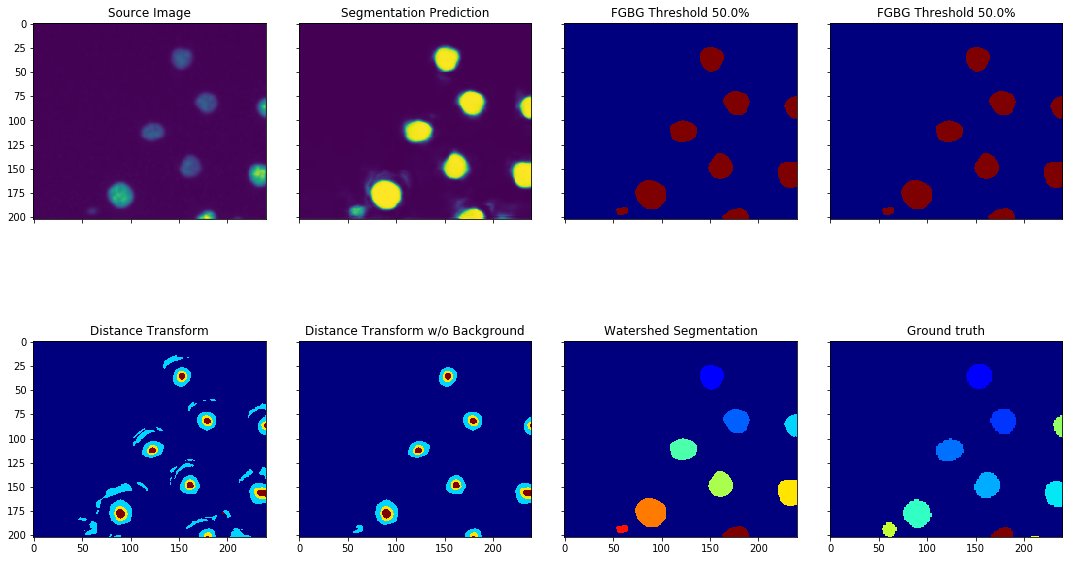

In [133]:
import matplotlib.pyplot as plt
%matplotlib inline

index = 0 #np.random.randint(low=0, high=1)
frame = 11 #np.random.randint(low=0, high=X_test.shape[1])
print('Image number:', index)
print('Frame:', frame)



fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(15, 10), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, frame, ..., 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, frame, ..., 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(fg_thresh[index, frame, ..., 0], cmap='jet')
ax[2].set_title('FGBG Threshold {}%'.format(threshold * 100))

fg_thresh_90 = test_images_fgbg[..., 1] > 0.5
fg_thresh_90 = np.expand_dims(fg_thresh_90.astype('int16'), axis=-1)
ax[3].imshow(fg_thresh_90[index, frame, ..., 0], cmap='jet')
ax[3].set_title('FGBG Threshold {}%'.format(0.5 * 100))

ax[4].imshow(argmax_images[index, frame, ..., 0], cmap='jet')
ax[4].set_title('Distance Transform')

ax[5].imshow(argmax_images_post_fgbg[index, frame, ..., 0], cmap='jet')
ax[5].set_title('Distance Transform w/o Background')

ax[6].imshow(watershed_images[index, frame, ..., 0], cmap='jet')
ax[6].set_title('Watershed Segmentation')

ax[7].imshow(y_test[index, frame, ..., 0], cmap='jet')
ax[7].set_title('Ground truth')

fig.tight_layout()
plt.show()
# plt.savefig('test.png')

### Make Predictions on ISBI Data for Metrics

In [ ]:
###### FOR ISBI Challenge Datasets

# Define data to load (raw images from trk test files)  
RAW_BASE_DIR = '/data/data/ISBI_Tracking_Challenge/tracks'

raw_trks_HeLa = os.path.join(RAW_BASE_DIR, 'ISBI_HeLa_Chal_GT.trks')
raw_trks_MSC  = os.path.join(RAW_BASE_DIR, 'ISBI_MSC_resized_Chal_GT_normalized.trks')
raw_trks_U373 = os.path.join(RAW_BASE_DIR, 'ISBI_U373_Chal_GT.trks')

#raw_trks_files = [raw_trks_HeLa, raw_trks_MSC, raw_trks_U373]
raw_trks_files = [raw_trks_HeLa]

# Define where segmentations will be saved
SEG_BASE_DIR = '/data/track_data/Final_Benchmarks/ISBI_DC_SEG/Watershed/HeLa_segmentations'
                             
DC_seg_HeLa  = os.path.join(SEG_BASE_DIR, 'HeLa/')
DC_seg_MSC   = os.path.join(SEG_BASE_DIR, 'MSC/')
DC_seg_U373  = os.path.join(SEG_BASE_DIR, 'U373/')

#DC_seg_folders = [DC_seg_HeLa, DC_seg_MSC, DC_seg_U373]
DC_seg_folders = [DC_seg_HeLa]

# Define a base file name for the output
BASE_NAME = 'batch_'

In [ ]:
# Instantiate new models for any image size

from deepcell import model_zoo

fgbg_model = model_zoo.bn_feature_net_skip_2D(
    n_features=2,  # segmentation mask (is_cell, is_not_cell)
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_conv_filters=32,
    n_dense_filters=128,
    input_shape=(None, None, 1),
    last_only=False)

fgbg_model.load_weights('/data/models/trackingSEG_cropped_conv_gru_fgbg_model.h5')


watershed_model = model_zoo.bn_feature_net_skip_2D(
    fgbg_model=fgbg_model,
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_features=distance_bins,
    n_conv_filters=32,
    n_dense_filters=128,
    last_only=False,
    input_shape=(None, None, 1))

watershed_model.load_weights('/data/models/trackingSEG_cropped_conv_gru_watershed_model.h5')

In [ ]:
# Run Predict for metric information only

CELL_TYPE_NAME = ['HeLa']
threshold = 0.9

from deepcell import metrics
from skimage.measure import label
from skimage import morphology
from skimage.morphology import watershed
from skimage.feature import peak_local_max

import tarfile
import pathlib
import tempfile
import json
import pandas as pd
from io import BytesIO


def load_trks(filename):
    """Load a trk/trks file.

    Args:
        trks_file: full path to the file including .trk/.trks

    Returns:
        A dictionary with raw, tracked, and lineage data
    """
    with tarfile.open(filename, 'r') as trks:

        # numpy can't read these from disk...
        array_file = BytesIO()
        array_file.write(trks.extractfile('raw.npy').read())
        array_file.seek(0)
        raw = np.load(array_file)
        array_file.close()

        array_file = BytesIO()
        array_file.write(trks.extractfile('tracked.npy').read())
        array_file.seek(0)
        tracked = np.load(array_file)
        array_file.close()

    return {'X': raw, 'y': tracked}


Lstats_AllDatasets = []

# Go through each Dataset
for set_num, dataset in enumerate(raw_trks_files):
    # Load the trk file       
    trks = load_trks(dataset)
    raw, tracked = trks['X'], trks['y']
    
    # Create an array for the new annotations
    y_new = np.zeros(tracked.shape)
                
    Lstats_allmovies = []

    # Go through each batch (movie) in each dataset
    for batch_num, movie in enumerate(trks['X']):

        Lstats = []
        # Predict on the raw data
        for frame_num, frame in enumerate(movie):
            
            image = np.expand_dims(frame, axis=0)
             
            test_image = watershed_model.predict(image)[-1]
            test_image_fgbg = fgbg_model.predict(image)[-1]

            # Postprocessing
            # Collapse predictions into semantic segmentation mask        
            max_image = np.argmax(test_image, axis=-1)
            argmax_image = np.expand_dims(max_image, axis=-1)
        
            # threshold the foreground/background
            # and remove background from watershed transform
            fg_thresh = test_image_fgbg[..., 1] > threshold

            fg_thresh = np.expand_dims(fg_thresh.astype('int16'), axis=-1)
            argmax_image_post_fgbg = argmax_image * fg_thresh
        
            # Apply watershed method with the distance transform as seed
            image = fg_thresh[..., 0]
            distance = argmax_image_post_fgbg[..., 0]

            local_maxi = peak_local_max(test_image[..., -1], min_distance=15, 
                                        exclude_border=False, indices=False, labels=image)

            markers = label(local_maxi)
            segments = watershed(-distance, markers, mask=image)
            watershed_image = np.expand_dims(segments, axis=-1)
            
            # Remove small objects from GT for comparison
            small_objects_threshold=50
            GT_image = trks['y'][batch_num, frame_num, :, :, :]
            GT_image = np.expand_dims(GT_image, axis=0)
            GT_image = morphology.remove_small_objects(GT_image.astype('uint16'), min_size=small_objects_threshold)
            
            # Accuracy from metrics package
            filename = CELL_TYPE_NAME[set_num] + BASE_NAME + '{}'.format(batch_num)
            
            m = metrics.Metrics(model_name = filename)
            m.calc_object_stats(GT_image, watershed_image)
            
            # Store results
            y_new[batch_num, frame_num, :, :, :] = watershed_image

            Lstats.append(m.stats)
            
    # Save results of this batch before moving on to the next
    filename = os.path.join(DC_seg_folders[set_num], 'all_batches.trks')
    filename = pathlib.Path(filename)

    with tarfile.open(str(filename), 'w') as trks:
        with tempfile.NamedTemporaryFile() as raw_file:
            np.save(raw_file, raw)
            raw_file.flush()
            trks.add(raw_file.name, 'raw.npy')

        with tempfile.NamedTemporaryFile() as tracked_file:
            np.save(tracked_file, y_new)
            tracked_file.flush()
            trks.add(tracked_file.name, 'tracked.npy')
                
        
        Lstats_allmovies.append(Lstats)
        
    Lstats_AllDatasets.append(Lstats_allmovies)
    
    
#df_HeLa   = pd.concat(Lstats_AllDatasets[0])
df_HeLa = pd.concat([pd.concat(Lstats_AllDatasets[0][0]) , pd.concat(Lstats_AllDatasets[0][1])])


In [ ]:
CELL_TYPE_DF = [df_HeLa]

for cell_type, df in zip(CELL_TYPE_NAME, CELL_TYPE_DF):
    print('\n')
    print(cell_type)
    print('\n')
    # Total number of correct detections and incorrect detections
    correct_det = int(df['correct_detections'].sum())
    incorrect_det = int(df['n_pred'].sum() - df['correct_detections'].sum())

    print('Correct Detections: ', correct_det)
    print('Incorrect Detections: ', incorrect_det)
    
    # Total number of splits, merges, and catastrophes
    splits = df['split'].sum()
    merges = df['merge'].sum()
    catastrophes = df['catastrophe'].sum()
    
    print('Splits: ', splits)
    print('Merges: ', merges)
    print('Catastrophes: ', catastrophes)

    # Average Recall, Precision, and Jaccard Index
    recall = 100 * df['correct_detections'].sum() / df['n_true'].sum()
    precision = 100 * df['correct_detections'].sum() / df['n_pred'].sum()
    jaccard = df['jaccard'].mean()

    print('Recall: ', recall)
    print('Precision: ', precision)
    print('Average Jaccard Index: ', jaccard)